# Differential abundance analysis

#### Working directory should contain integrated Seurat object of WT and mutants, which is available on GEO under record GSE152766:

    rc.integrated_wt_shr_scr.rds
    
#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are available on Github (github.com/Hsu-Che-Wei/COPILOT):

    features.tsv.gz

#### The file 'Benfey_single_cell-Samples.csv' contains the meta data of samples, which is not provided. But one can find an example of such file in Supplementary Dataset 1 (This study)

In [3]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [4]:
# Load libraries
library(edgeR)
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(ggplot2)
library(scater)
library(RColorBrewer)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQR

In [5]:
library(future)
#for 300gb ram 
options(future.globals.maxSize = 300000 * 1024^2)


Attaching package: ‘future’


The following object is masked from ‘package:SummarizedExperiment’:

    values


The following object is masked from ‘package:GenomicRanges’:

    values


The following object is masked from ‘package:IRanges’:

    values


The following object is masked from ‘package:S4Vectors’:

    values




In [8]:
rc.integrated <- readRDS("./rc.integrated_wt_shr_scr.rds")

In [7]:
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




## 1. Add metadata and organize by genotype and experiment date

In [9]:
  bscs <- read.csv("./Benfey_single_cell-Samples.csv", na.strings=c("","NA"), stringsAsFactors = F)
  bscs <- bscs %>% select(c('sample','name','source','geno', 'genotype','transgene','treatment','age','timepoint','rep','target_cells','date','seq_run'))
  bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)
  bscs$target_cells <- prettyNum(bscs$target_cells, big.mark = ',')

orig.idents <- data.frame(sample=rc.integrated$orig.ident)

bscs %>% filter(sample %in% orig.idents$sample)

sample,name,source,geno,genotype,transgene,treatment,age,timepoint,rep,target_cells,date,seq_run
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_20,WT Col-0_RS1,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_21,WT Col-0_RS2,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_25,scr-4_1,Benfey lab,scr-4,scr-4 (Ws backcrossed to Col?),NA,Untreated,5_day,NA,NA,"10,000",NA,Shahan_6177
sc_30,WT Col-0_RS3,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_31,WT Col-0_RS4,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",NA,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_36,scr_4_2,Benfey lab,scr-4,scr-4,NA,Untreated,5_day,NA,NA,"10,000",NA,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4)
sc_51,WT Col (RS_5),Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2020-02-24,Nolan_6226
sc_52,shr-2,Benfey lab,shr-2,shr-2,NA,Untreated,5_day,NA,NA,"10,000",2020-02-24,Nolan_6226


In [10]:
orig.idents_info <- left_join(orig.idents, bscs, by="sample")
orig.idents_info 

sample,name,source,geno,genotype,transgene,treatment,age,timepoint,rep,target_cells,date,seq_run
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158
sc_12,WT Col-0 untreated,Benfey lab,WT,WT Col-0,NA,Untreated,5_day,NA,NA,"10,000",2019-12-20,Nolan_6131;Shahan_6158


In [11]:
treatment <- orig.idents_info$treatment
names(treatment) <- colnames(rc.integrated)
head(treatment)
rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = treatment,
  col.name = 'treatment')


timepoint <- orig.idents_info$timepoint
names(timepoint) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = timepoint,
  col.name = 'timepoint')



age <- orig.idents_info$age
names(age) <- colnames(rc.integrated)
rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = age,
  col.name = 'age')



rep <- orig.idents_info$rep
names(rep) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = rep,
  col.name = 'rep')

date <- orig.idents_info$date
names(date) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = date,
  col.name = 'date')

geno <- orig.idents_info$geno

names(geno) <- colnames(rc.integrated)

rc.integrated <- AddMetaData(
  object = rc.integrated,
  metadata = geno,
  col.name = 'geno')

AAACCCAAGCCATTCA_1 AAACCCAAGCTGTTCA_1 AAACCCAAGGCGAACT_1 AAACCCACACCAGCCA_1 
       "Untreated"        "Untreated"        "Untreated"        "Untreated" 
AAACCCACACTGGCGT_1 AAACCCACAGACCTGC_1 
       "Untreated"        "Untreated"

In [12]:
table(rc.integrated$treatment)


Untreated 
    86260 

In [13]:
table(rc.integrated$geno)


scr-4 shr-2    WT 
13742 14612 57906 

In [14]:
rc.integrated$geno_trt <- rep("WT")
rc.integrated$geno_trt[rc.integrated$geno=="WT"] <- "WT"
rc.integrated$geno_trt[rc.integrated$geno=="shr-2"] <- "shr"
rc.integrated$geno_trt[rc.integrated$geno=="scr-4"] <- "scr"
rc.integrated$geno_trt <- factor(rc.integrated$geno_trt, levels=c("WT", "shr", "scr"))

In [15]:
table(rc.integrated$geno_trt)


   WT   shr   scr 
57906 14612 13742 

In [16]:
table(rc.integrated$celltype.anno)


           Quiescent Center                   Columella 
                         12                        7403 
           Lateral Root Cap                Atrichoblast 
                      17762                       11553 
                Trichoblast                      Cortex 
                      10824                        9953 
                 Endodermis Metaphloem & Companion Cell 
                       6056                        1908 
                Protophloem                  Procambium 
                        546                        7114 
       Xylem Pole Pericycle       Phloem Pole Pericycle 
                       7095                        2232 
                 Protoxylem                   Metaxylem 
                       2369                        1433 

In [17]:
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Metaphloem & Companion Cell","Protophloem", "Xylem", "Procambium","Xylem Pole Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]

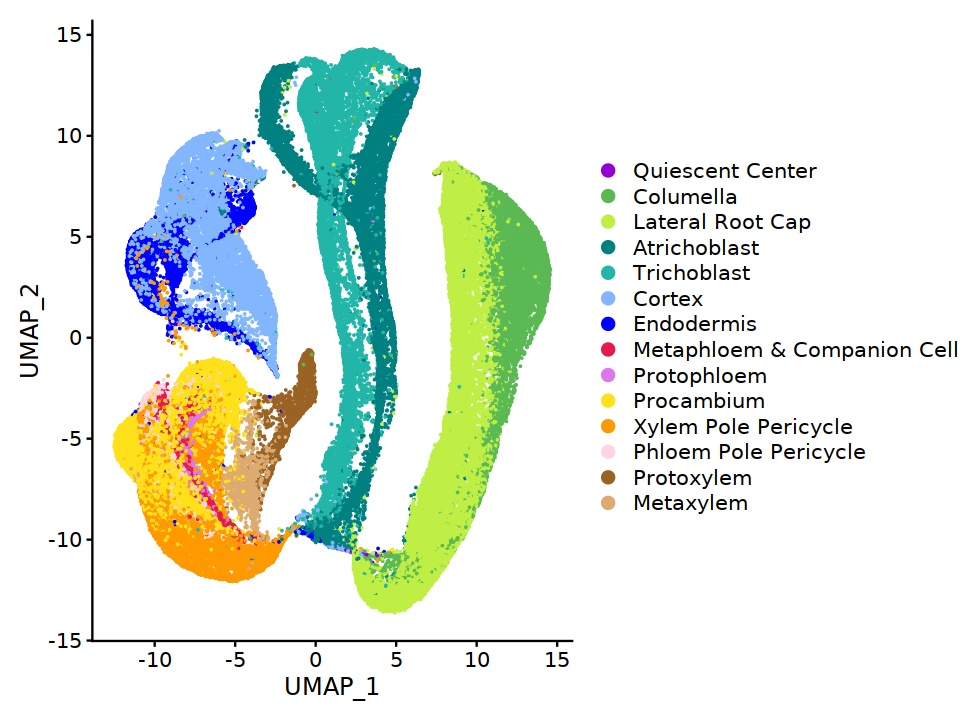

In [19]:
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color)

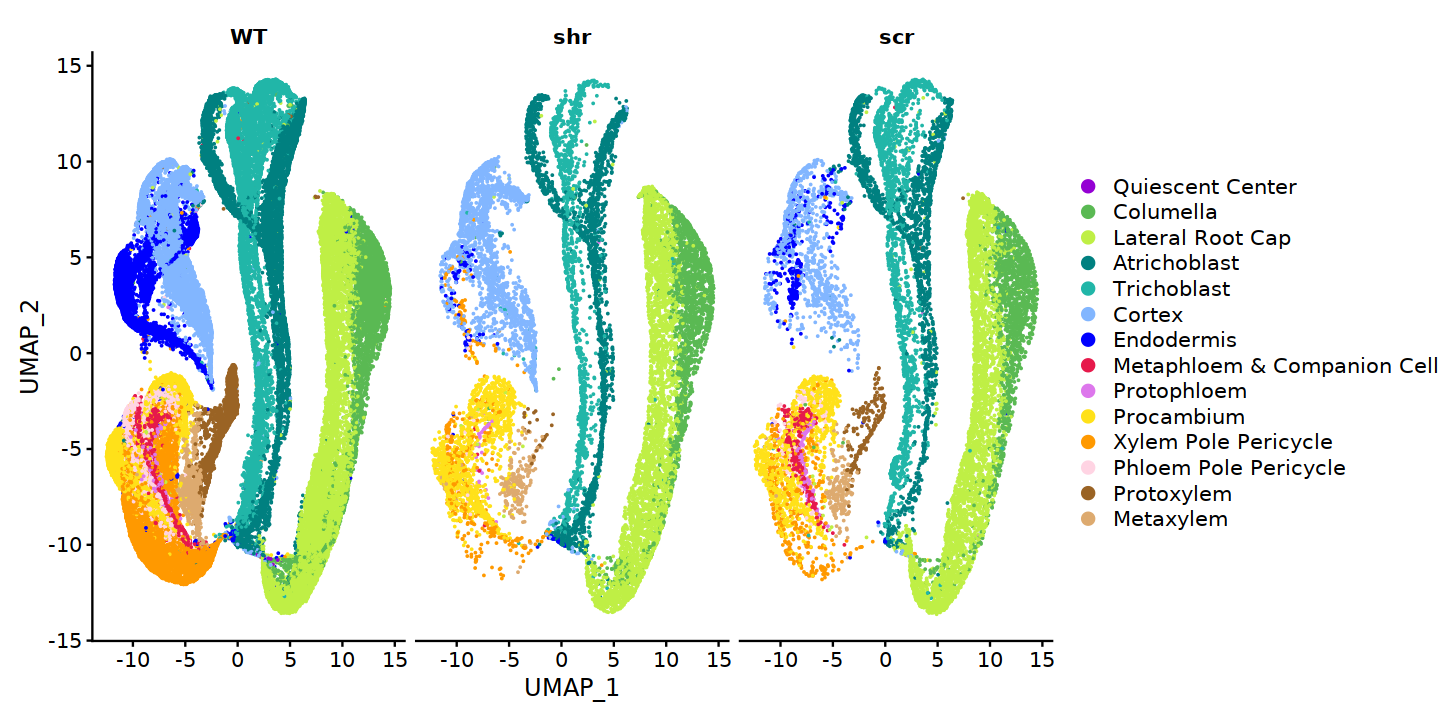

In [20]:
options(repr.plot.width=12, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", split.by="geno_trt", cols=color)

## 2. Draw a heatmap of each celltype's numbers 

In [21]:
sample_num_df <- data.frame(table(rc.integrated$geno_trt))

sample_num_df <- dplyr::rename(sample_num_df, "total_cells"="Freq", "orig.id"="Var1")

sample_num_df

rc.integrated$sample.cell.p <- paste(rc.integrated$geno_trt, rc.integrated$celltype.anno, sep = ",")

sample_cell_df <- data.frame(table(rc.integrated$sample.cell.p))

sample_cell_df <- separate(sample_cell_df, col="Var1", sep=",", into=c("orig.id", "celltype")) %>%
  dplyr::rename("n_celltype"="Freq") %>%
  left_join(sample_num_df) %>%
  mutate(proportion=n_celltype/total_cells)

sample_cell_df

wt_cells <- filter(sample_cell_df, orig.id == "WT") %>%
  group_by(celltype) %>%
  summarise(wt_prop=mean(proportion))

wt_cells

sample_cell_df <- left_join(sample_cell_df, wt_cells) %>%
  mutate(wt_norm_prop=proportion/wt_prop)

sample_cell_df


sample_cell_wide <- sample_cell_df %>%
  ungroup() %>%
  select(orig.id, celltype, wt_norm_prop) %>%
  pivot_wider(names_from = celltype, values_from = wt_norm_prop)

sample_cell_wide

sample_cell_wide[is.na(sample_cell_wide)==T] <- 0.0000001

sample_cell_wide

cell_m <- as.matrix(log2(sample_cell_wide[, -1]))
rownames(cell_m) <- sample_cell_wide$orig.id

cell_m

orig.id,total_cells
<fct>,<int>
WT,57906
shr,14612
scr,13742


Joining, by = "orig.id"



orig.id,celltype,n_celltype,total_cells,proportion
<chr>,<chr>,<int>,<int>,<dbl>
scr,Atrichoblast,1990,13742,1.448115e-01
scr,Columella,1626,13742,1.183234e-01
scr,Cortex,999,13742,7.269684e-02
scr,Endodermis,321,13742,2.335905e-02
scr,Lateral Root Cap,4422,13742,3.217872e-01
scr,Metaphloem & Companion Cell,319,13742,2.321351e-02
scr,Metaxylem,204,13742,1.484500e-02
scr,Phloem Pole Pericycle,131,13742,9.532819e-03
scr,Procambium,1078,13742,7.844564e-02


`summarise()` ungrouping output (override with `.groups` argument)



celltype,wt_prop
<chr>,<dbl>
Atrichoblast,0.128121438
Columella,0.066228025
Cortex,0.113166166
Endodermis,0.097036577
Lateral Root Cap,0.155527925
Metaphloem & Companion Cell,0.027337409
Metaxylem,0.017183021
Phloem Pole Pericycle,0.035816668
Procambium,0.078541084


Joining, by = "celltype"



orig.id,celltype,n_celltype,total_cells,proportion,wt_prop,wt_norm_prop
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
scr,Atrichoblast,1990,13742,1.448115e-01,0.128121438,1.13026773
scr,Columella,1626,13742,1.183234e-01,0.066228025,1.78660603
scr,Cortex,999,13742,7.269684e-02,0.113166166,0.64239025
scr,Endodermis,321,13742,2.335905e-02,0.097036577,0.24072413
scr,Lateral Root Cap,4422,13742,3.217872e-01,0.155527925,2.06899965
scr,Metaphloem & Companion Cell,319,13742,2.321351e-02,0.027337409,0.84914800
scr,Metaxylem,204,13742,1.484500e-02,0.017183021,0.86393428
scr,Phloem Pole Pericycle,131,13742,9.532819e-03,0.035816668,0.26615594
scr,Procambium,1078,13742,7.844564e-02,0.078541084,0.99878481


orig.id,Atrichoblast,Columella,Cortex,Endodermis,Lateral Root Cap,Metaphloem & Companion Cell,Metaxylem,Phloem Pole Pericycle,Procambium,Protophloem,Protoxylem,Quiescent Center,Trichoblast,Xylem Pole Pericycle
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
scr,1.130268,1.786606,0.6423903,0.24072413,2.069000,0.84914800,0.8639343,0.2661559,0.9987848,1.2749437,0.3699060,0.3830725,1.1203756,0.2512815
shr,1.145232,2.006771,1.4519976,0.08181122,1.907089,0.01502049,0.9319802,0.0515904,1.2965712,0.3861294,0.0496974,NA,0.7815466,0.2482302
WT,1.000000,1.000000,1.0000000,1.00000000,1.000000,1.00000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000


orig.id,Atrichoblast,Columella,Cortex,Endodermis,Lateral Root Cap,Metaphloem & Companion Cell,Metaxylem,Phloem Pole Pericycle,Procambium,Protophloem,Protoxylem,Quiescent Center,Trichoblast,Xylem Pole Pericycle
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
scr,1.130268,1.786606,0.6423903,0.24072413,2.069000,0.84914800,0.8639343,0.2661559,0.9987848,1.2749437,0.3699060,0.3830725,1.1203756,0.2512815
shr,1.145232,2.006771,1.4519976,0.08181122,1.907089,0.01502049,0.9319802,0.0515904,1.2965712,0.3861294,0.0496974,0.0000001,0.7815466,0.2482302
WT,1.000000,1.000000,1.0000000,1.00000000,1.000000,1.00000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000


,Atrichoblast,Columella,Cortex,Endodermis,Lateral Root Cap,Metaphloem & Companion Cell,Metaxylem,Phloem Pole Pericycle,Procambium,Protophloem,Protoxylem,Quiescent Center,Trichoblast,Xylem Pole Pericycle
scr,0.1766645,0.8372215,-0.6384781,-2.054547,1.0489334,-0.2359121,-0.2110065,-1.909656,-0.001754222,0.3504336,-1.434769,-1.384311,0.1639825,-1.992624
shr,0.1956393,1.0048758,0.5380391,-3.611558,0.9313719,-6.0569239,-0.1016288,-4.276753,0.374701456,-1.3728436,-4.330686,-23.253497,-0.3555962,-2.010250
WT,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000000,0.0000000,0.000000,0.000000,0.0000000,0.000000


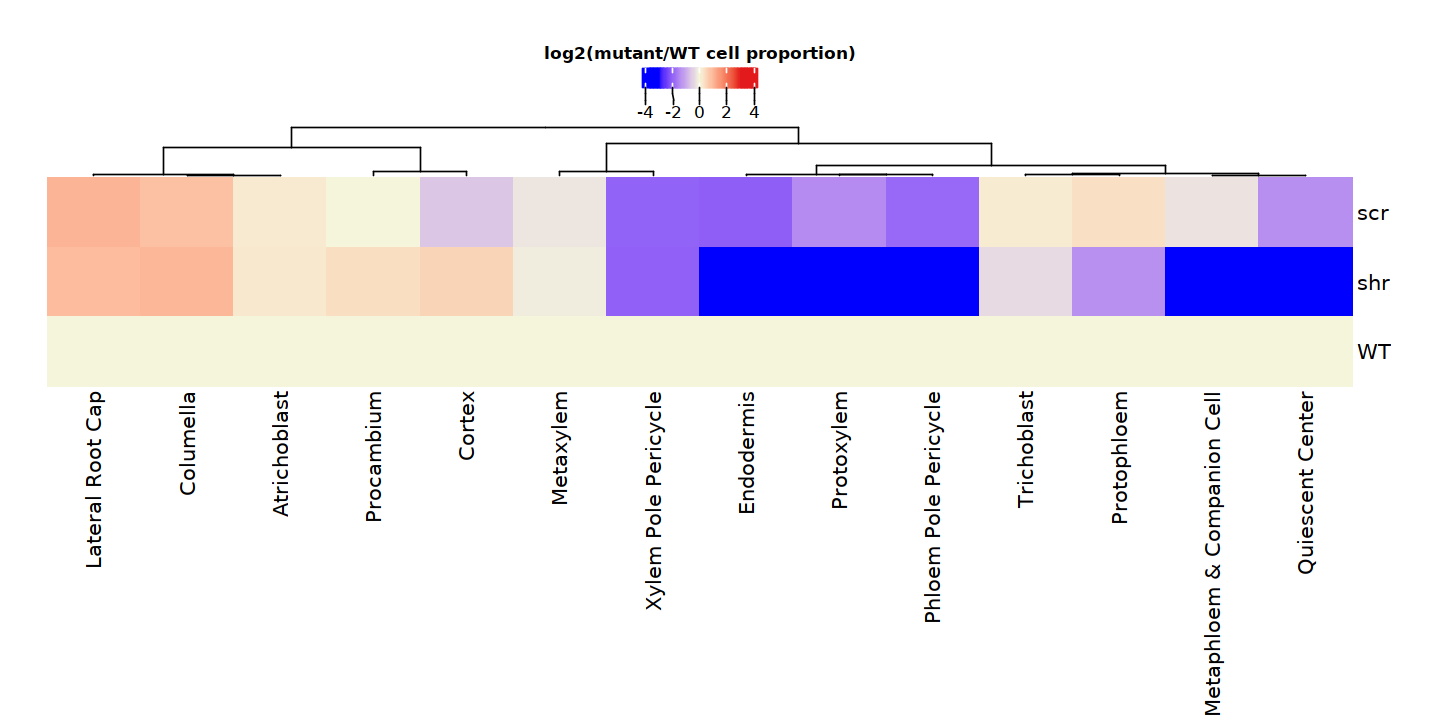

In [22]:

# add to hm cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))})

Cell_hm <- Heatmap(cell_m, name = "log2(mutant/WT cell proportion)", 
                   heatmap_legend_param = list(title_position="topcenter", 
                                               color_bar = "continuous", 
                                               legend_direction = "horizontal"), 
                   col = colorRamp2(c(-3, 0, 3), c("blue", "beige", "#e31a1c")), 
                   cluster_rows = F, 
                   cluster_columns = T, 
                   use_raster= FALSE, 
                   show_column_names = TRUE, show_row_names = TRUE, show_row_dend = TRUE, show_column_dend = TRUE,
                   clustering_distance_rows = "pearson", clustering_distance_columns = "pearson",
                 row_names_gp = gpar(fontsize = 12)) 


draw(Cell_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")

In [23]:
sample_num_df <- data.frame(table(rc.integrated$orig.ident))

sample_num_df <- dplyr::rename(sample_num_df, "total_cells"="Freq", "orig.id"="Var1")

sample_num_df

rc.integrated$sample.cell.p <- paste(rc.integrated$orig.ident, rc.integrated$celltype.anno, sep = ",")

sample_cell_df <- data.frame(table(rc.integrated$sample.cell.p))

sample_cell_df <- separate(sample_cell_df, col="Var1", sep=",", into=c("orig.id", "celltype")) %>%
  dplyr::rename("n_celltype"="Freq") %>%
  left_join(sample_num_df) %>%
  mutate(proportion=n_celltype/total_cells)

sample_cell_df

wt_cells <- filter(sample_cell_df, orig.id %in% c("sc_12", "sc_20", "sc_21", "sc_30", "sc_31", "sc_51")) %>%
  group_by(celltype) %>%
  summarise(wt_prop=mean(proportion))

wt_cells

sample_cell_df <- left_join(sample_cell_df, wt_cells) %>%
  mutate(wt_norm_prop=proportion/wt_prop)

sample_cell_df


sample_cell_wide <- sample_cell_df %>%
  ungroup() %>%
  select(orig.id, celltype, wt_norm_prop) %>%
  pivot_wider(names_from = celltype, values_from = wt_norm_prop)

sample_cell_wide

sample_cell_wide[is.na(sample_cell_wide)==T] <- 0.0000001

sample_cell_wide

cell_m <- as.matrix(log2(sample_cell_wide[, -1]))
rownames(cell_m) <- sample_cell_wide$orig.id

cell_m

orig.id,total_cells
<fct>,<int>
sc_12,10293
sc_20,12591
sc_21,9658
sc_25,7736
sc_30,10195
sc_31,8775
sc_36,6006
sc_51,6394
sc_52,6241


Joining, by = "orig.id"



orig.id,celltype,n_celltype,total_cells,proportion
<chr>,<chr>,<int>,<int>,<dbl>
sc_12,Atrichoblast,1369,10293,1.330030e-01
sc_12,Columella,866,10293,8.413485e-02
sc_12,Cortex,1158,10293,1.125036e-01
sc_12,Endodermis,697,10293,6.771592e-02
sc_12,Lateral Root Cap,1796,10293,1.744875e-01
sc_12,Metaphloem & Companion Cell,265,10293,2.574565e-02
sc_12,Metaxylem,117,10293,1.136695e-02
sc_12,Phloem Pole Pericycle,306,10293,2.972894e-02
sc_12,Procambium,854,10293,8.296901e-02


`summarise()` ungrouping output (override with `.groups` argument)



celltype,wt_prop
<chr>,<dbl>
Atrichoblast,0.127022281
Columella,0.067144369
Cortex,0.112971608
Endodermis,0.098700348
Lateral Root Cap,0.159813068
Metaphloem & Companion Cell,0.027495016
Metaxylem,0.016861260
Phloem Pole Pericycle,0.035137864
Procambium,0.077841275


Joining, by = "celltype"



orig.id,celltype,n_celltype,total_cells,proportion,wt_prop,wt_norm_prop
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
sc_12,Atrichoblast,1369,10293,1.330030e-01,0.127022281,1.0470841
sc_12,Columella,866,10293,8.413485e-02,0.067144369,1.2530440
sc_12,Cortex,1158,10293,1.125036e-01,0.112971608,0.9958577
sc_12,Endodermis,697,10293,6.771592e-02,0.098700348,0.6860758
sc_12,Lateral Root Cap,1796,10293,1.744875e-01,0.159813068,1.0918226
sc_12,Metaphloem & Companion Cell,265,10293,2.574565e-02,0.027495016,0.9363753
sc_12,Metaxylem,117,10293,1.136695e-02,0.016861260,0.6741458
sc_12,Phloem Pole Pericycle,306,10293,2.972894e-02,0.035137864,0.8460657
sc_12,Procambium,854,10293,8.296901e-02,0.077841275,1.0658742


orig.id,Atrichoblast,Columella,Cortex,Endodermis,Lateral Root Cap,Metaphloem & Companion Cell,Metaxylem,Phloem Pole Pericycle,Procambium,Protophloem,Protoxylem,Trichoblast,Xylem Pole Pericycle,Quiescent Center
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sc_12,1.0470841,1.2530440,0.9958577,0.68607583,1.0918226,0.936375254,0.6741458,0.84606572,1.0658742,0.3103248,0.69333622,1.0476540,1.1077096,NA
sc_20,1.0004142,0.9226241,0.9926706,0.78214515,0.9382736,0.927237175,1.1869988,1.24316024,1.0315279,0.8879046,1.18983582,1.1542012,0.9988871,0.1528798
sc_21,0.9374125,0.7263135,0.9788468,0.97561184,0.7185087,1.043130382,1.3693915,1.05786901,1.1878301,1.0072178,1.20145351,1.1935097,1.1910805,NA
sc_25,1.1794705,1.7153456,0.7700684,0.27896162,2.0989815,0.780436646,1.0349688,0.30902063,0.9083661,1.1260835,0.44364813,0.9031146,0.2536160,0.2488249
sc_30,1.1644858,0.9013394,0.9976162,1.36546577,0.8519026,0.995320617,0.9773093,0.95190102,0.8631642,1.1677837,0.98587921,0.9526578,0.9259129,NA
sc_31,0.9554821,0.9877937,1.1005463,1.12112341,0.9804903,1.102504925,1.0408390,1.08648148,0.9896682,1.6049460,1.06471057,0.8481066,0.9354782,0.4387258
sc_36,1.0892706,1.8226044,0.4804663,0.18218799,1.9034476,0.926514307,0.6813554,0.22270870,1.1357932,1.4020983,0.28571944,1.4547311,0.2542470,NA
sc_51,0.8951213,1.2088854,0.9344624,1.06957799,1.4190022,0.995431646,0.7513155,0.81452253,0.8619354,1.0218230,0.86478466,0.8038707,0.8409316,2.4083945
sc_52,1.0066275,2.2097707,1.5289570,0.07630008,1.8458114,0.023310513,0.8837689,0.03192041,1.3441541,0.4420132,0.02182229,0.8133312,0.2001874,NA


orig.id,Atrichoblast,Columella,Cortex,Endodermis,Lateral Root Cap,Metaphloem & Companion Cell,Metaxylem,Phloem Pole Pericycle,Procambium,Protophloem,Protoxylem,Trichoblast,Xylem Pole Pericycle,Quiescent Center
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sc_12,1.0470841,1.2530440,0.9958577,0.68607583,1.0918226,0.936375254,0.6741458,0.84606572,1.0658742,0.3103248,0.69333622,1.0476540,1.1077096,0.0000001
sc_20,1.0004142,0.9226241,0.9926706,0.78214515,0.9382736,0.927237175,1.1869988,1.24316024,1.0315279,0.8879046,1.18983582,1.1542012,0.9988871,0.1528798
sc_21,0.9374125,0.7263135,0.9788468,0.97561184,0.7185087,1.043130382,1.3693915,1.05786901,1.1878301,1.0072178,1.20145351,1.1935097,1.1910805,0.0000001
sc_25,1.1794705,1.7153456,0.7700684,0.27896162,2.0989815,0.780436646,1.0349688,0.30902063,0.9083661,1.1260835,0.44364813,0.9031146,0.2536160,0.2488249
sc_30,1.1644858,0.9013394,0.9976162,1.36546577,0.8519026,0.995320617,0.9773093,0.95190102,0.8631642,1.1677837,0.98587921,0.9526578,0.9259129,0.0000001
sc_31,0.9554821,0.9877937,1.1005463,1.12112341,0.9804903,1.102504925,1.0408390,1.08648148,0.9896682,1.6049460,1.06471057,0.8481066,0.9354782,0.4387258
sc_36,1.0892706,1.8226044,0.4804663,0.18218799,1.9034476,0.926514307,0.6813554,0.22270870,1.1357932,1.4020983,0.28571944,1.4547311,0.2542470,0.0000001
sc_51,0.8951213,1.2088854,0.9344624,1.06957799,1.4190022,0.995431646,0.7513155,0.81452253,0.8619354,1.0218230,0.86478466,0.8038707,0.8409316,2.4083945
sc_52,1.0066275,2.2097707,1.5289570,0.07630008,1.8458114,0.023310513,0.8837689,0.03192041,1.3441541,0.4420132,0.02182229,0.8133312,0.2001874,0.0000001


,Atrichoblast,Columella,Cortex,Endodermis,Lateral Root Cap,Metaphloem & Companion Cell,Metaxylem,Phloem Pole Pericycle,Procambium,Protophloem,Protoxylem,Trichoblast,Xylem Pole Pericycle,Quiescent Center
sc_12,0.0663773274,0.3254371,-0.005988519,-0.54356005,0.12673844,-0.094841286,-0.568867364,-0.24115836,0.09203719,-1.68814900,-0.52837296,0.06716227,0.147579723,-23.253497
sc_20,0.0005974486,-0.1161852,-0.010613021,-0.35449173,-0.09191948,-0.108989686,0.247318503,0.31401227,0.04478288,-0.17152342,0.25076251,0.20689479,-0.001606414,-2.709531
sc_21,-0.0932440949,-0.4613357,-0.030844962,-0.03562082,-0.47692238,0.060919493,0.453534980,0.08116099,0.24832846,0.01037573,0.26478083,0.25521025,0.252270927,-23.253497
sc_25,0.2381392790,0.7784993,-0.376941530,-1.84186144,1.06968946,-0.357646573,0.049587346,-1.69422495,-0.13865421,0.17131381,-1.17251220,-0.14701906,-1.979282531,-2.006797
sc_30,0.2196930658,-0.1498577,-0.003443218,0.44939315,-0.23123959,-0.006766768,-0.033112904,-0.07111652,-0.21229313,0.22377314,-0.02051720,-0.06997001,-0.111051624,-23.253497
sc_31,-0.0656991875,-0.0177183,0.138219831,0.16494509,-0.02842479,0.140785101,0.057746959,0.11966358,-0.01498313,0.68252472,0.09046131,-0.23768250,-0.096224022,-1.188609
sc_36,0.1233624146,0.8660014,-1.057492751,-2.45650024,0.92861487,-0.110114841,-0.553520475,-2.16677020,0.18370014,0.48758753,-1.80732888,0.54075248,-1.975697451,-23.253497
sc_51,-0.1598449674,0.2736775,-0.097791482,0.09704168,0.50487687,-0.006605842,-0.412509198,-0.29597348,-0.21434835,0.03114536,-0.20958716,-0.31496455,-0.249939581,1.268072
sc_52,0.0095299473,1.1438967,0.612547821,-3.71217163,0.88425513,-5.422875421,-0.178258857,-4.96937687,0.42669853,-1.17783869,-5.51805345,-0.29808516,-2.320576805,-23.253497
sc_53,0.3401249399,0.8540902,0.484380939,-3.58185879,0.89802562,-6.846498187,-0.001489082,-3.87842646,0.35776897,-1.60146146,-3.80417269,-0.34582018,-1.793109172,-23.253497


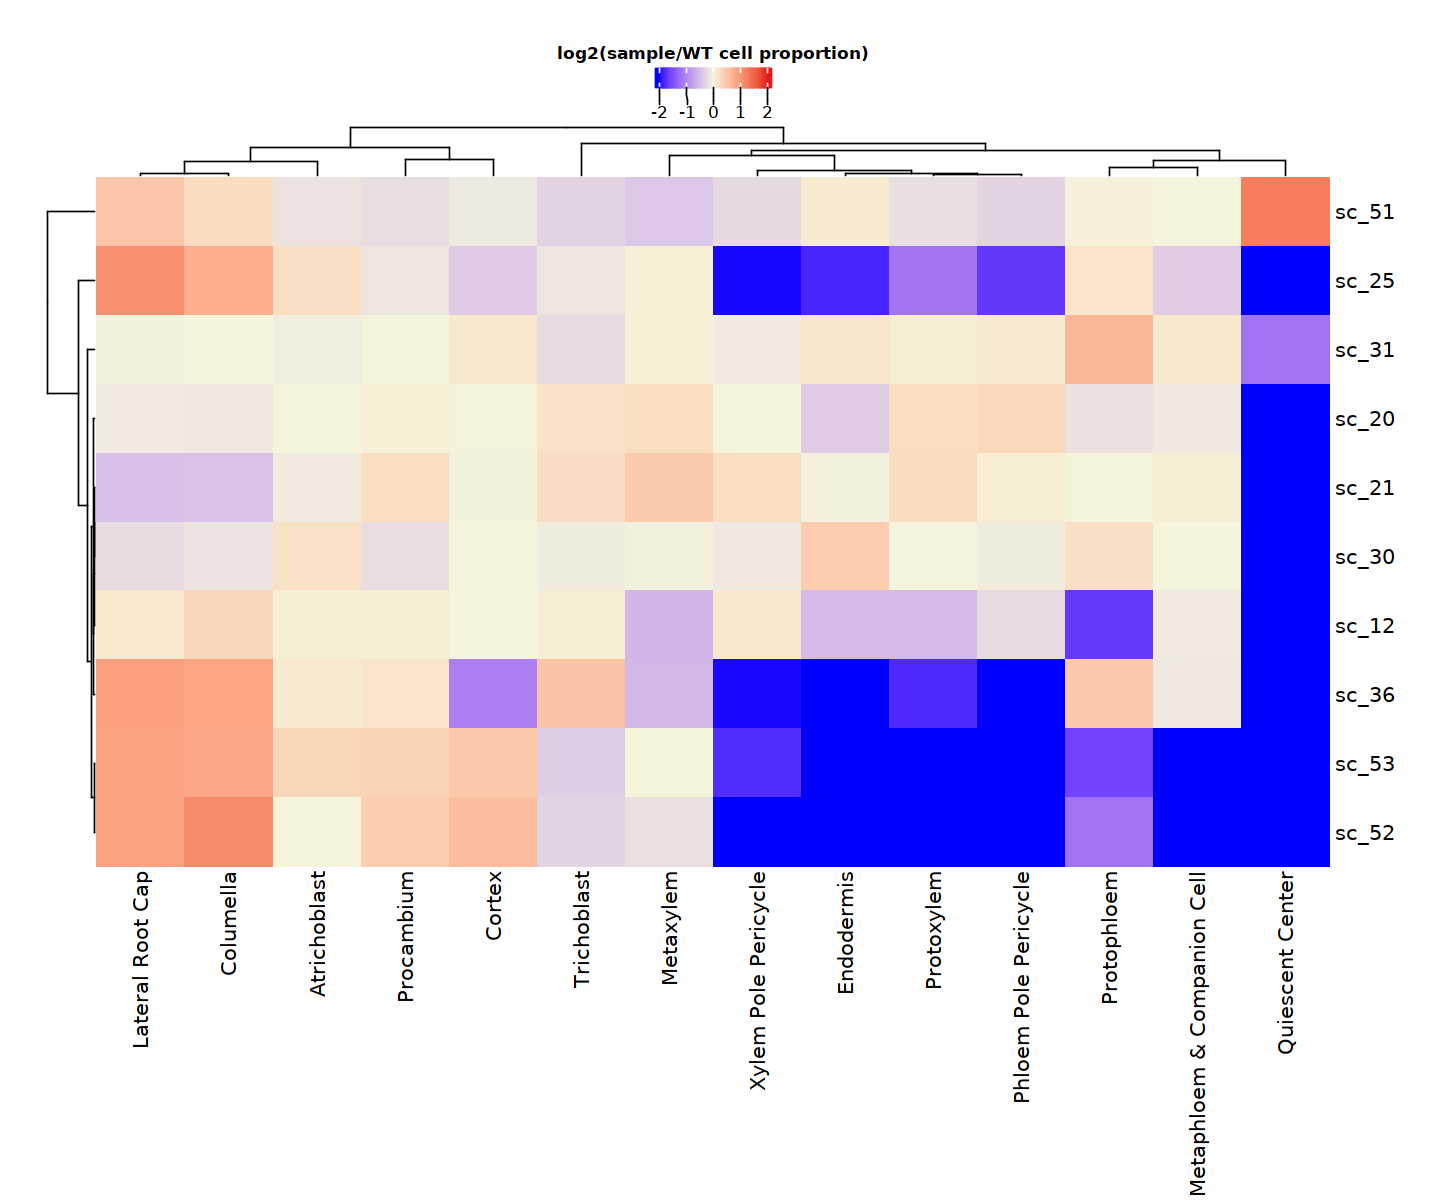

In [24]:
options(repr.plot.width=12, repr.plot.height=10)
# add to hm cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))})

Cell_hm <- Heatmap(cell_m, name = "log2(sample/WT cell proportion)", 
                   heatmap_legend_param = list(title_position="topcenter", 
                                               color_bar = "continuous", 
                                               legend_direction = "horizontal"), 
                   col = colorRamp2(c(-2, 0, 2), c("blue", "beige", "#e31a1c")), 
                   cluster_rows = T, 
                   cluster_columns = T, 
                   use_raster= FALSE, 
                   show_column_names = TRUE, show_row_names = TRUE, show_row_dend = TRUE, show_column_dend = TRUE,
                   clustering_distance_rows = "pearson", clustering_distance_columns = "pearson",
                 row_names_gp = gpar(fontsize = 12)) 


draw(Cell_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")

In [25]:
table(rc.integrated$batch)


batch 1 batch 2 batch 3 batch 4 
  10293   29985   24976   21006 

In [26]:
table(rc.integrated$batch, rc.integrated$orig.ident)

         
          sc_12 sc_20 sc_21 sc_25 sc_30 sc_31 sc_36 sc_51 sc_52 sc_53
  batch 1 10293     0     0     0     0     0     0     0     0     0
  batch 2     0 12591  9658  7736     0     0     0     0     0     0
  batch 3     0     0     0     0 10195  8775  6006     0     0     0
  batch 4     0     0     0     0     0     0     0  6394  6241  8371

In [27]:
rc.integrated$batch<- gsub(" ", "_", rc.integrated$batch, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)
table(rc.integrated$batch, rc.integrated$orig.ident)

         
          sc_12 sc_20 sc_21 sc_25 sc_30 sc_31 sc_36 sc_51 sc_52 sc_53
  batch_1 10293     0     0     0     0     0     0     0     0     0
  batch_2     0 12591  9658  7736     0     0     0     0     0     0
  batch_3     0     0     0     0 10195  8775  6006     0     0     0
  batch_4     0     0     0     0     0     0     0  6394  6241  8371

## 3. shr DA analysis

In [28]:
# subset only samples you want to compare
integrated.de <- subset(rc.integrated, subset = geno_trt %in% c("WT", "shr"))

In [29]:
DefaultAssay(integrated.de) <- "RNA"
merged <- as.SingleCellExperiment(integrated.de)

In [30]:
merged

class: SingleCellExperiment 
dim: 28429 72518 
metadata(0):
assays(2): counts logcounts
rownames(28429): AT1G01010 AT1G01020 ... AT4G07645 AT4G29600
rowData names(0):
colnames(72518): AAACCCAAGCCATTCA_1 AAACCCAAGCTGTTCA_1 ...
  TTTGTTGTCCTTTGAT_10 TTTGTTGTCTCGCTTG_10
colData names(107): orig.ident nCount_RNA ... sample.cell.p ident
reducedDimNames(5): PCA UMAP UMAP_50 UMAP_3D UMAP_2D
altExpNames(0):

In [31]:
abundances <- table(merged$celltype.anno, merged$orig.ident) 
abundances <- unclass(abundances) 
abundances

,sc_12,sc_20,sc_21,sc_30,sc_31,sc_51,sc_52,sc_53
Quiescent Center,0,1,0,0,2,8,0,0
Columella,866,780,471,617,582,519,926,1016
Lateral Root Cap,1796,1888,1109,1388,1375,1450,1841,2493
Atrichoblast,1369,1600,1150,1508,1065,727,798,1346
Trichoblast,1349,1818,1442,1215,931,643,635,824
Cortex,1158,1412,1068,1149,1091,675,1078,1323
Endodermis,697,972,930,1374,971,675,47,69
Metaphloem & Companion Cell,265,321,277,279,266,175,4,2
Protophloem,22,77,67,82,97,45,19,19
Procambium,854,1011,893,685,676,429,653,835


In [32]:
# Attaching some column metadata.
extra.info <- colData(merged)[match(colnames(abundances), merged$orig.ident),]
y.ab <- DGEList(abundances, samples=extra.info)
y.ab

,sc_12,sc_20,sc_21,sc_30,sc_31,sc_51,sc_52,sc_53
Quiescent Center,0,1,0,0,2,8,0,0
Columella,866,780,471,617,582,519,926,1016
Lateral Root Cap,1796,1888,1109,1388,1375,1450,1841,2493
Atrichoblast,1369,1600,1150,1508,1065,727,798,1346
Trichoblast,1349,1818,1442,1215,931,643,635,824
Cortex,1158,1412,1068,1149,1091,675,1078,1323
Endodermis,697,972,930,1374,971,675,47,69
Metaphloem & Companion Cell,265,321,277,279,266,175,4,2
Protophloem,22,77,67,82,97,45,19,19
Procambium,854,1011,893,685,676,429,653,835


In [33]:
keep <- filterByExpr(y.ab, group=y.ab$samples$orig.ident)
y.ab <- y.ab[keep,]
summary(keep)

   Mode   FALSE    TRUE 
logical       1      13 

In [34]:
(design <- model.matrix(~batch + factor(geno_trt), y.ab$samples))

,(Intercept),batchbatch_2,batchbatch_3,batchbatch_4,factor(geno_trt)shr
sc_12,1,0,0,0,0
sc_20,1,1,0,0,0
sc_21,1,1,0,0,0
sc_30,1,0,1,0,0
sc_31,1,0,1,0,0
sc_51,1,0,0,1,0
sc_52,1,0,0,1,1
sc_53,1,0,0,1,1


In [35]:
y.ab <- estimateDisp(y.ab, design, trend="none")
summary(y.ab$common.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.009713 0.009713 0.009713 0.009713 0.009713 0.009713 

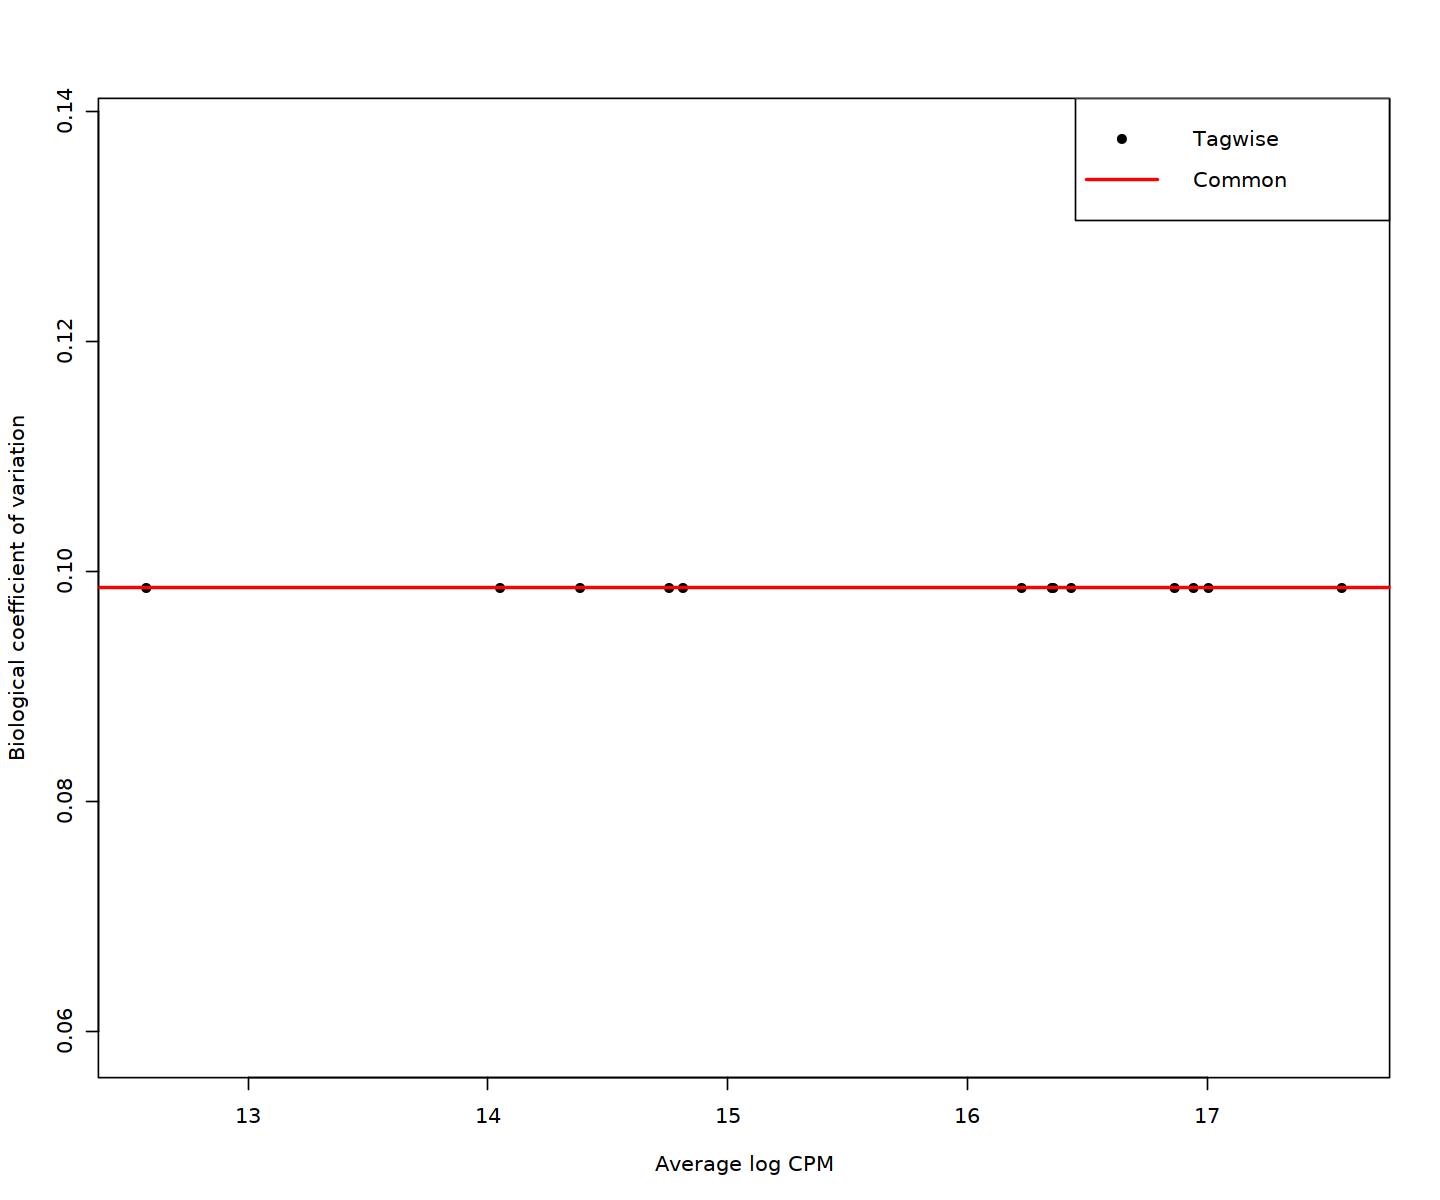

In [36]:
plotBCV(y.ab, cex=1)

In [37]:
fit.ab <- glmQLFit(y.ab, design, robust=TRUE, abundance.trend=FALSE)
summary(fit.ab$var.prior)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.351   1.351   1.351   1.351   1.351   1.351 

In [38]:
summary(fit.ab$df.prior)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    Inf     Inf     Inf     Inf     Inf     Inf 

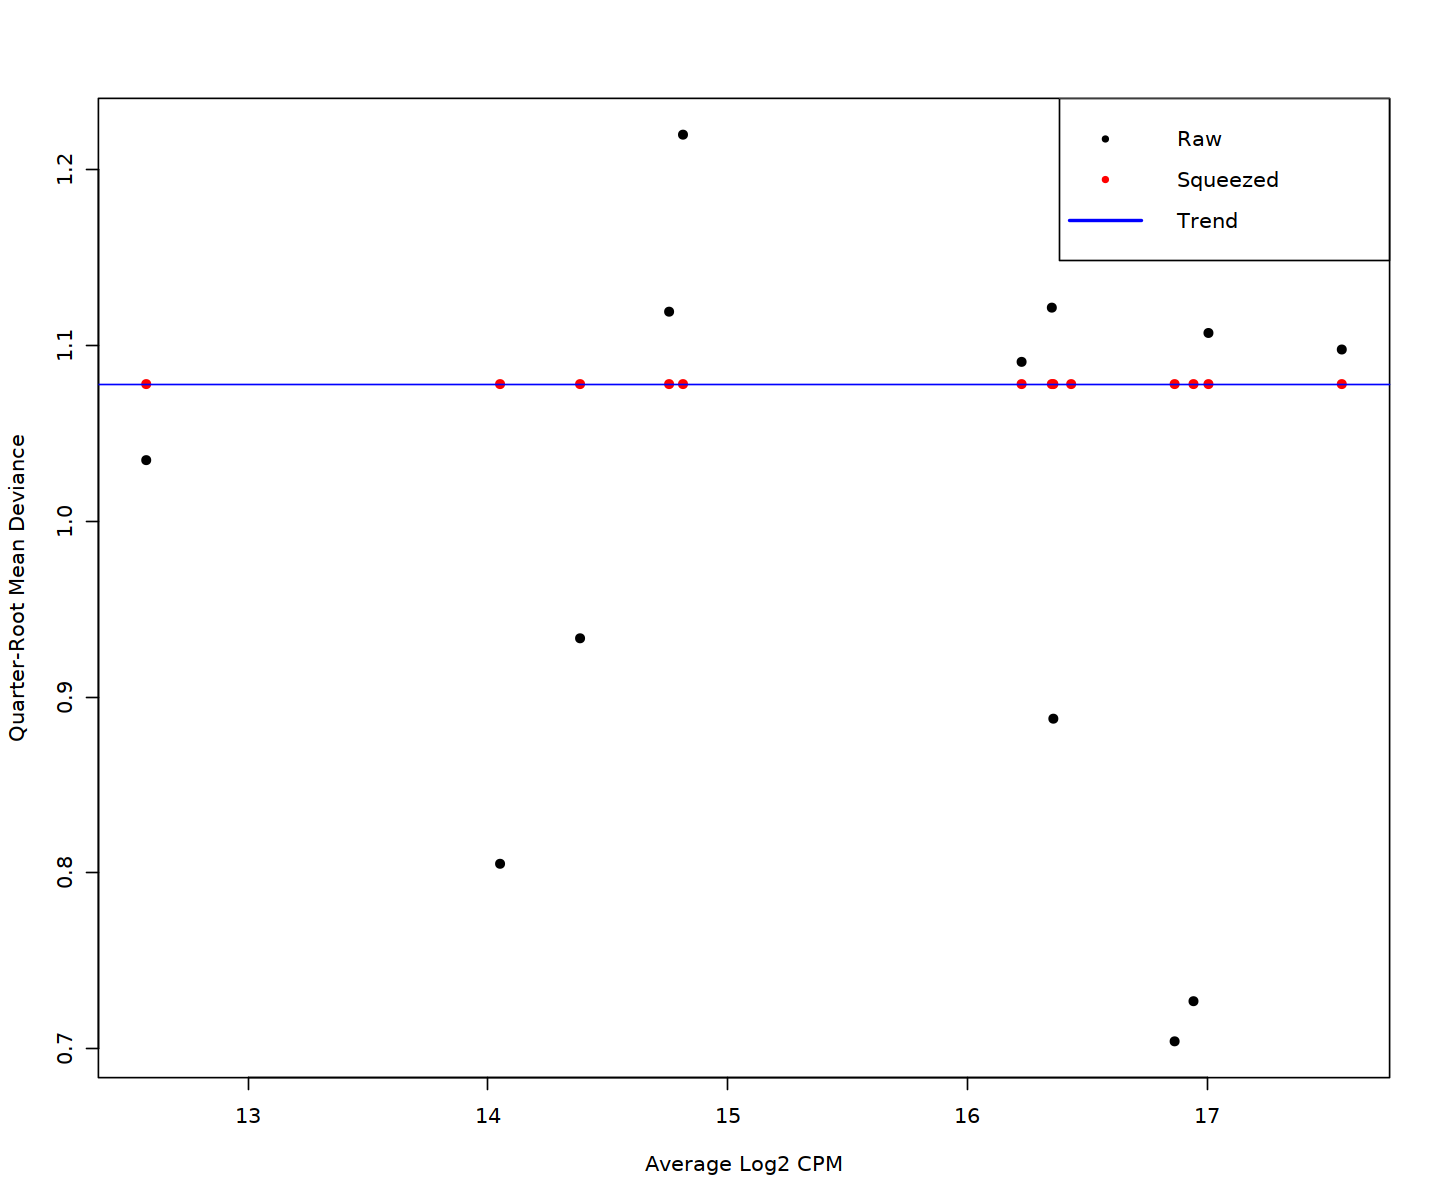

In [39]:
plotQLDisp(fit.ab, cex=1)

In [40]:
res <- glmQLFTest(fit.ab, coef=ncol(design))
summary(decideTests(res))

       factor(geno_trt)shr
Down                     6
NotSig                   4
Up                       3

In [41]:
topTags(res, n = nrow(res$table))

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Endodermis,-3.734158406,16.22613,2.282362e+02,6.876860e-18,8.939917e-17
Metaphloem & Companion Cell,-6.008830357,14.38444,1.799999e+02,3.396628e-16,2.207808e-15
Protoxylem,-4.104489094,14.81374,1.466473e+02,8.677350e-15,3.760185e-14
Phloem Pole Pericycle,-3.951323250,14.75583,1.320241e+02,4.343998e-14,1.411799e-13
Xylem Pole Pericycle,-1.769131659,16.43285,6.258140e+01,1.245411e-09,3.238068e-09
Protophloem,-1.426689500,12.57477,1.156678e+01,1.562531e-03,3.385485e-03
Columella,0.730448936,16.35220,1.065672e+01,2.286870e-03,4.247044e-03
Cortex,0.646862453,16.94312,8.654415e+00,5.466543e-03,8.883132e-03
Procambium,0.606271377,16.35854,7.188467e+00,1.069847e-02,1.545335e-02


In [42]:
shr_DA_results <- topTags(res, n = nrow(res$table))$table

In [43]:
shr_DA_results

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Endodermis,-3.734158406,16.22613,2.282362e+02,6.876860e-18,8.939917e-17
Metaphloem & Companion Cell,-6.008830357,14.38444,1.799999e+02,3.396628e-16,2.207808e-15
Protoxylem,-4.104489094,14.81374,1.466473e+02,8.677350e-15,3.760185e-14
Phloem Pole Pericycle,-3.951323250,14.75583,1.320241e+02,4.343998e-14,1.411799e-13
Xylem Pole Pericycle,-1.769131659,16.43285,6.258140e+01,1.245411e-09,3.238068e-09
Protophloem,-1.426689500,12.57477,1.156678e+01,1.562531e-03,3.385485e-03
Columella,0.730448936,16.35220,1.065672e+01,2.286870e-03,4.247044e-03
Cortex,0.646862453,16.94312,8.654415e+00,5.466543e-03,8.883132e-03
Procambium,0.606271377,16.35854,7.188467e+00,1.069847e-02,1.545335e-02


## 4. scr DA analysis

In [44]:
# subset only samples you want to compare
integrated.de <- subset(rc.integrated, subset = geno_trt %in% c("WT", "scr"))

DefaultAssay(integrated.de) <- "RNA"
merged <- as.SingleCellExperiment(integrated.de)

merged

class: SingleCellExperiment 
dim: 28429 71648 
metadata(0):
assays(2): counts logcounts
rownames(28429): AT1G01010 AT1G01020 ... AT4G07645 AT4G29600
rowData names(0):
colnames(71648): AAACCCAAGCCATTCA_1 AAACCCAAGCTGTTCA_1 ...
  TTTGTTGGTGGCTTGC_8 TTTGTTGTCTAAGCCA_8
colData names(107): orig.ident nCount_RNA ... sample.cell.p ident
reducedDimNames(5): PCA UMAP UMAP_50 UMAP_3D UMAP_2D
altExpNames(0):

In [45]:
abundances <- table(merged$celltype.anno, merged$orig.ident) 
abundances <- unclass(abundances) 
abundances

# Attaching some column metadata.
extra.info <- colData(merged)[match(colnames(abundances), merged$orig.ident),]
y.ab <- DGEList(abundances, samples=extra.info)
y.ab

keep <- filterByExpr(y.ab, group=y.ab$samples$orig.ident)
y.ab <- y.ab[keep,]
summary(keep)

,sc_12,sc_20,sc_21,sc_25,sc_30,sc_31,sc_36,sc_51
Quiescent Center,0,1,0,1,0,2,0,8
Columella,866,780,471,891,617,582,735,519
Lateral Root Cap,1796,1888,1109,2595,1388,1375,1827,1450
Atrichoblast,1369,1600,1150,1159,1508,1065,831,727
Trichoblast,1349,1818,1442,874,1215,931,1093,643
Cortex,1158,1412,1068,673,1149,1091,326,675
Endodermis,697,972,930,213,1374,971,108,675
Metaphloem & Companion Cell,265,321,277,166,279,266,153,175
Protophloem,22,77,67,60,82,97,58,45
Procambium,854,1011,893,547,685,676,531,429


,sc_12,sc_20,sc_21,sc_25,sc_30,sc_31,sc_36,sc_51
Quiescent Center,0,1,0,1,0,2,0,8
Columella,866,780,471,891,617,582,735,519
Lateral Root Cap,1796,1888,1109,2595,1388,1375,1827,1450
Atrichoblast,1369,1600,1150,1159,1508,1065,831,727
Trichoblast,1349,1818,1442,874,1215,931,1093,643
Cortex,1158,1412,1068,673,1149,1091,326,675
Endodermis,697,972,930,213,1374,971,108,675
Metaphloem & Companion Cell,265,321,277,166,279,266,153,175
Protophloem,22,77,67,60,82,97,58,45
Procambium,854,1011,893,547,685,676,531,429


   Mode   FALSE    TRUE 
logical       1      13 

In [46]:
(design <- model.matrix(~batch + factor(geno_trt), y.ab$samples))

,(Intercept),batchbatch_2,batchbatch_3,batchbatch_4,factor(geno_trt)scr
sc_12,1,0,0,0,0
sc_20,1,1,0,0,0
sc_21,1,1,0,0,0
sc_25,1,1,0,0,1
sc_30,1,0,1,0,0
sc_31,1,0,1,0,0
sc_36,1,0,1,0,1
sc_51,1,0,0,1,0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02084 0.02084 0.02084 0.02084 0.02084 0.02084 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9743  0.9743  0.9743  0.9743  0.9743  0.9743 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.97     Inf     Inf     Inf     Inf     Inf 

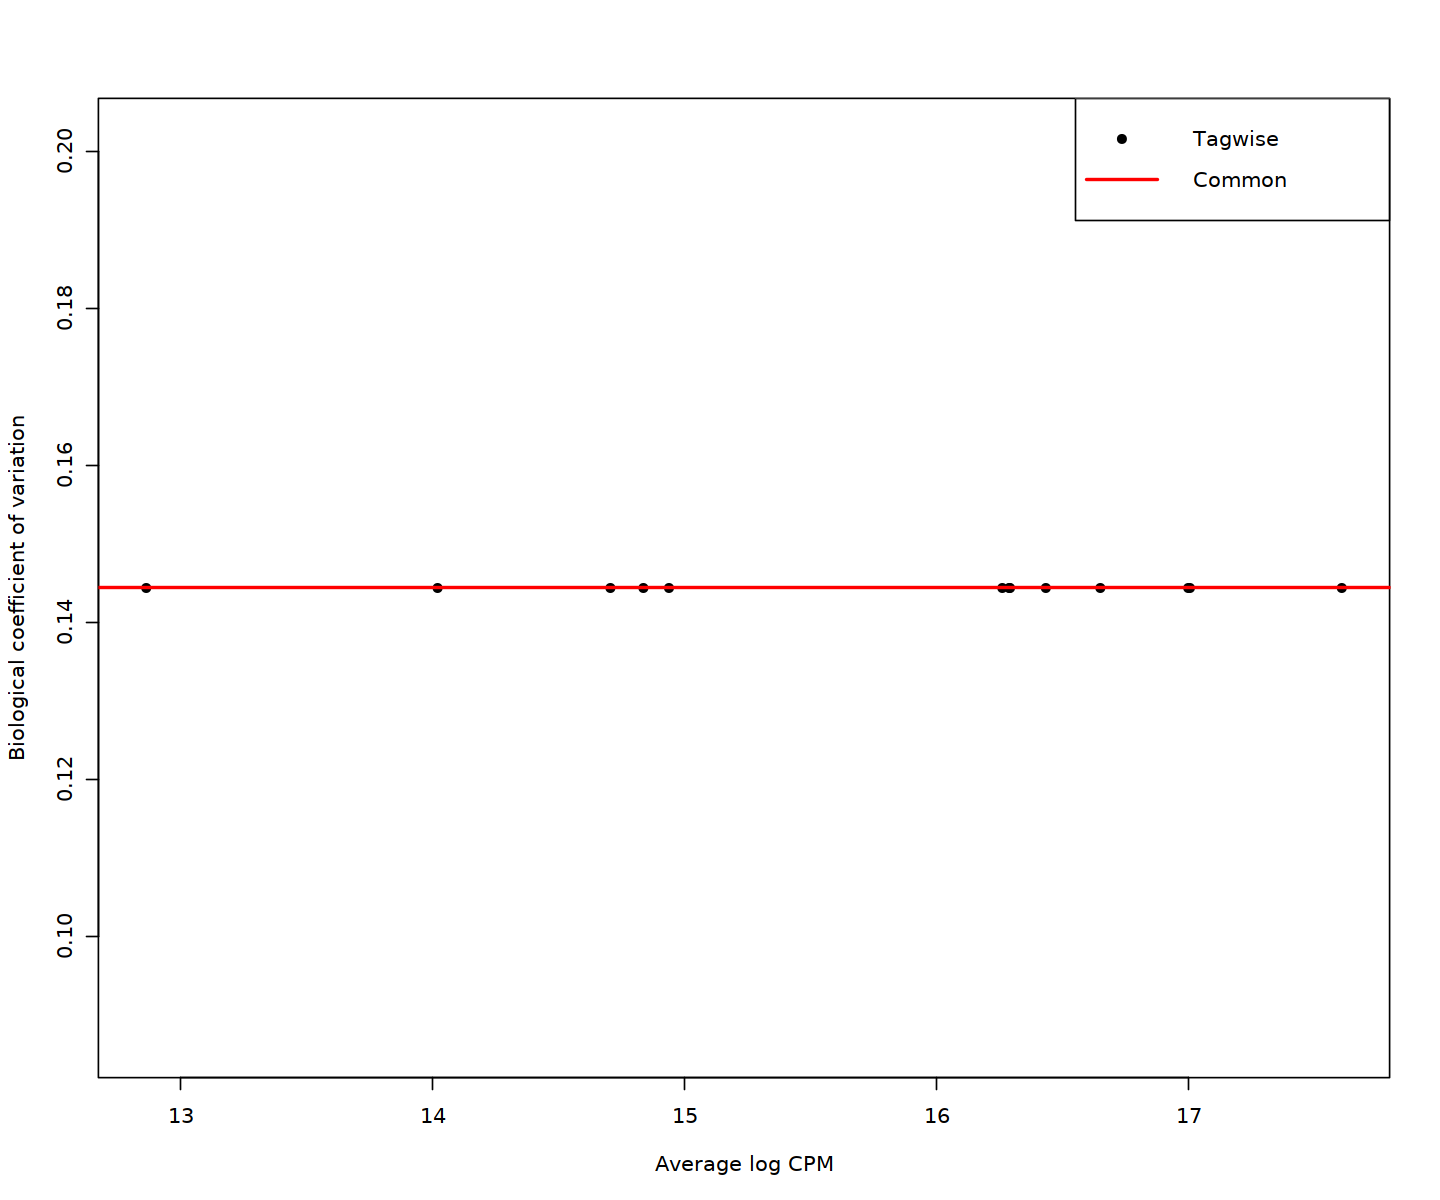

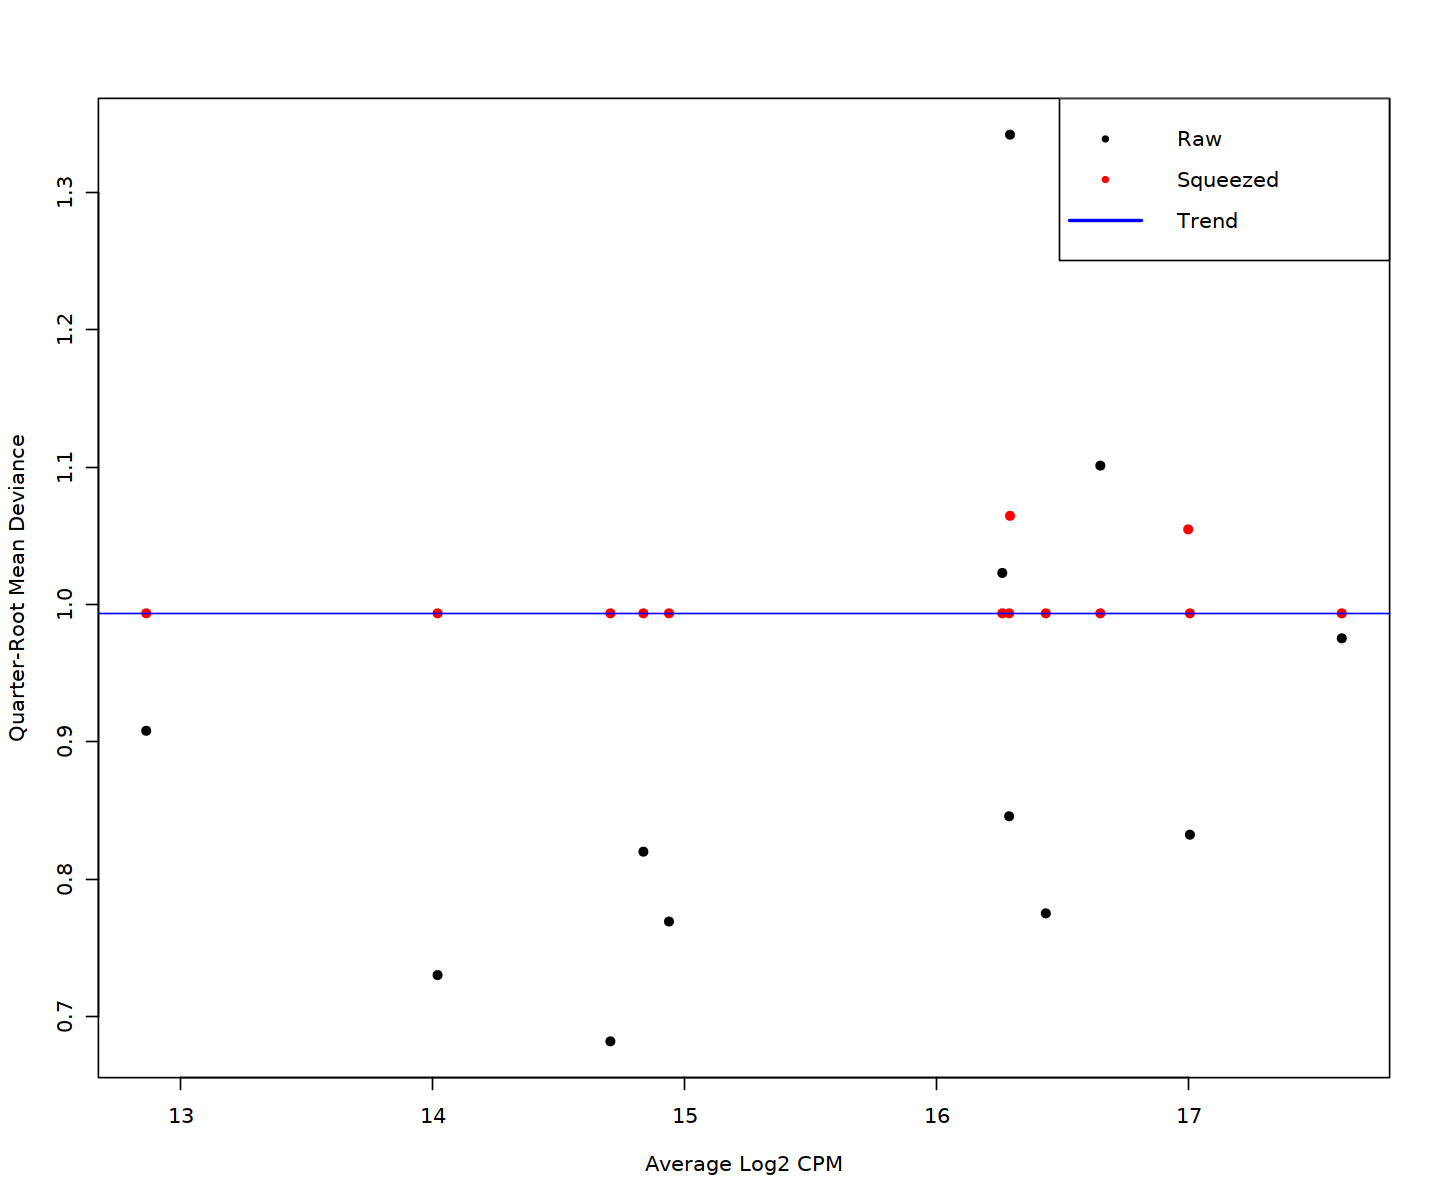

In [47]:
y.ab <- estimateDisp(y.ab, design, trend="none")
summary(y.ab$common.dispersion)

plotBCV(y.ab, cex=1)

fit.ab <- glmQLFit(y.ab, design, robust=TRUE, abundance.trend=FALSE)
summary(fit.ab$var.prior)

summary(fit.ab$df.prior)

plotQLDisp(fit.ab, cex=1)

In [48]:
res <- glmQLFTest(fit.ab, coef=ncol(design))
summary(decideTests(res))

topTags(res, n = nrow(res$table))

(scr_DA_results <- topTags(res, n = nrow(res$table))$table)

       factor(geno_trt)scr
Down                     5
NotSig                   6
Up                       2

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Xylem Pole Pericycle,-1.99158781,16.43261,91.415763310,8.978192e-12,1.167165e-10
Phloem Pole Pericycle,-2.02924105,14.83612,79.362871453,6.073171e-11,3.947561e-10
Protoxylem,-1.61485601,14.93765,55.189763894,5.561377e-09,2.409930e-08
Endodermis,-2.15998154,16.29054,78.253372896,1.081519e-08,3.514937e-08
Lateral Root Cap,1.20038501,17.60659,47.106446000,3.302030e-08,8.585278e-08
Columella,1.00230305,16.28703,31.339009319,1.871833e-06,4.055638e-06
Cortex,-0.71776248,16.64879,14.099129454,5.655683e-04,1.050341e-03
Metaxylem,-0.42115626,14.01975,3.906227326,5.521042e-02,8.971694e-02
Metaphloem & Companion Cell,-0.25648055,14.70530,1.631745622,2.090141e-01,3.019092e-01


,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Xylem Pole Pericycle,-1.99158781,16.43261,91.415763310,8.978192e-12,1.167165e-10
Phloem Pole Pericycle,-2.02924105,14.83612,79.362871453,6.073171e-11,3.947561e-10
Protoxylem,-1.61485601,14.93765,55.189763894,5.561377e-09,2.409930e-08
Endodermis,-2.15998154,16.29054,78.253372896,1.081519e-08,3.514937e-08
Lateral Root Cap,1.20038501,17.60659,47.106446000,3.302030e-08,8.585278e-08
Columella,1.00230305,16.28703,31.339009319,1.871833e-06,4.055638e-06
Cortex,-0.71776248,16.64879,14.099129454,5.655683e-04,1.050341e-03
Metaxylem,-0.42115626,14.01975,3.906227326,5.521042e-02,8.971694e-02
Metaphloem & Companion Cell,-0.25648055,14.70530,1.631745622,2.090141e-01,3.019092e-01


In [49]:
y.ab2 <- calcNormFactors(y.ab)
y.ab2$samples$norm.factors

y.ab2 <- estimateDisp(y.ab2, design, trend="none")
fit.ab2 <- glmQLFit(y.ab2, design, robust=TRUE, abundance.trend=FALSE)
res2 <- glmQLFTest(fit.ab2, coef=ncol(design))
summary(decideTests(res2))
topTags(res, n = nrow(res$table))$table

(scr_DA_results_adj <- topTags(res, n = nrow(res$table))$table)

[1] 0.9607095 1.0605795 1.0831872 0.8019815 1.0428403 1.1112540 1.0313922
[8] 0.9452394

       factor(geno_trt)scr
Down                     4
NotSig                   7
Up                       2

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Xylem Pole Pericycle,-1.99158781,16.43261,91.415763310,8.978192e-12,1.167165e-10
Phloem Pole Pericycle,-2.02924105,14.83612,79.362871453,6.073171e-11,3.947561e-10
Protoxylem,-1.61485601,14.93765,55.189763894,5.561377e-09,2.409930e-08
Endodermis,-2.15998154,16.29054,78.253372896,1.081519e-08,3.514937e-08
Lateral Root Cap,1.20038501,17.60659,47.106446000,3.302030e-08,8.585278e-08
Columella,1.00230305,16.28703,31.339009319,1.871833e-06,4.055638e-06
Cortex,-0.71776248,16.64879,14.099129454,5.655683e-04,1.050341e-03
Metaxylem,-0.42115626,14.01975,3.906227326,5.521042e-02,8.971694e-02
Metaphloem & Companion Cell,-0.25648055,14.70530,1.631745622,2.090141e-01,3.019092e-01


,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Xylem Pole Pericycle,-1.99158781,16.43261,91.415763310,8.978192e-12,1.167165e-10
Phloem Pole Pericycle,-2.02924105,14.83612,79.362871453,6.073171e-11,3.947561e-10
Protoxylem,-1.61485601,14.93765,55.189763894,5.561377e-09,2.409930e-08
Endodermis,-2.15998154,16.29054,78.253372896,1.081519e-08,3.514937e-08
Lateral Root Cap,1.20038501,17.60659,47.106446000,3.302030e-08,8.585278e-08
Columella,1.00230305,16.28703,31.339009319,1.871833e-06,4.055638e-06
Cortex,-0.71776248,16.64879,14.099129454,5.655683e-04,1.050341e-03
Metaxylem,-0.42115626,14.01975,3.906227326,5.521042e-02,8.971694e-02
Metaphloem & Companion Cell,-0.25648055,14.70530,1.631745622,2.090141e-01,3.019092e-01


## 5. Combine shr and scr DA results to plot

In [50]:
(shr_DA_results <- rownames_to_column(shr_DA_results, var = "celltype"))

shr_DA_results$geno <- rep("shr")

(scr_DA_results <- rownames_to_column(scr_DA_results, var = "celltype"))

scr_DA_results$geno <- rep("scr")

(DA_results <- bind_rows(shr_DA_results, scr_DA_results))

(DA_results <- mutate(DA_results, star = case_when(FDR <=0.001 ~ "***",  
                                          FDR <=0.01 ~ "**", 
                                          FDR <=0.05 ~ "*", 
                                          TRUE ~ " ")))

celltype,logFC,logCPM,F,PValue,FDR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Endodermis,-3.734158406,16.22613,2.282362e+02,6.876860e-18,8.939917e-17
Metaphloem & Companion Cell,-6.008830357,14.38444,1.799999e+02,3.396628e-16,2.207808e-15
Protoxylem,-4.104489094,14.81374,1.466473e+02,8.677350e-15,3.760185e-14
Phloem Pole Pericycle,-3.951323250,14.75583,1.320241e+02,4.343998e-14,1.411799e-13
Xylem Pole Pericycle,-1.769131659,16.43285,6.258140e+01,1.245411e-09,3.238068e-09
Protophloem,-1.426689500,12.57477,1.156678e+01,1.562531e-03,3.385485e-03
Columella,0.730448936,16.35220,1.065672e+01,2.286870e-03,4.247044e-03
Cortex,0.646862453,16.94312,8.654415e+00,5.466543e-03,8.883132e-03
Procambium,0.606271377,16.35854,7.188467e+00,1.069847e-02,1.545335e-02


celltype,logFC,logCPM,F,PValue,FDR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Xylem Pole Pericycle,-1.99158781,16.43261,91.415763310,8.978192e-12,1.167165e-10
Phloem Pole Pericycle,-2.02924105,14.83612,79.362871453,6.073171e-11,3.947561e-10
Protoxylem,-1.61485601,14.93765,55.189763894,5.561377e-09,2.409930e-08
Endodermis,-2.15998154,16.29054,78.253372896,1.081519e-08,3.514937e-08
Lateral Root Cap,1.20038501,17.60659,47.106446000,3.302030e-08,8.585278e-08
Columella,1.00230305,16.28703,31.339009319,1.871833e-06,4.055638e-06
Cortex,-0.71776248,16.64879,14.099129454,5.655683e-04,1.050341e-03
Metaxylem,-0.42115626,14.01975,3.906227326,5.521042e-02,8.971694e-02
Metaphloem & Companion Cell,-0.25648055,14.70530,1.631745622,2.090141e-01,3.019092e-01


celltype,logFC,logCPM,F,PValue,FDR,geno
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Endodermis,-3.734158406,16.22613,2.282362e+02,6.876860e-18,8.939917e-17,shr
Metaphloem & Companion Cell,-6.008830357,14.38444,1.799999e+02,3.396628e-16,2.207808e-15,shr
Protoxylem,-4.104489094,14.81374,1.466473e+02,8.677350e-15,3.760185e-14,shr
Phloem Pole Pericycle,-3.951323250,14.75583,1.320241e+02,4.343998e-14,1.411799e-13,shr
Xylem Pole Pericycle,-1.769131659,16.43285,6.258140e+01,1.245411e-09,3.238068e-09,shr
Protophloem,-1.426689500,12.57477,1.156678e+01,1.562531e-03,3.385485e-03,shr
Columella,0.730448936,16.35220,1.065672e+01,2.286870e-03,4.247044e-03,shr
Cortex,0.646862453,16.94312,8.654415e+00,5.466543e-03,8.883132e-03,shr
Procambium,0.606271377,16.35854,7.188467e+00,1.069847e-02,1.545335e-02,shr


celltype,logFC,logCPM,F,PValue,FDR,geno,star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Endodermis,-3.734158406,16.22613,2.282362e+02,6.876860e-18,8.939917e-17,shr,***
Metaphloem & Companion Cell,-6.008830357,14.38444,1.799999e+02,3.396628e-16,2.207808e-15,shr,***
Protoxylem,-4.104489094,14.81374,1.466473e+02,8.677350e-15,3.760185e-14,shr,***
Phloem Pole Pericycle,-3.951323250,14.75583,1.320241e+02,4.343998e-14,1.411799e-13,shr,***
Xylem Pole Pericycle,-1.769131659,16.43285,6.258140e+01,1.245411e-09,3.238068e-09,shr,***
Protophloem,-1.426689500,12.57477,1.156678e+01,1.562531e-03,3.385485e-03,shr,**
Columella,0.730448936,16.35220,1.065672e+01,2.286870e-03,4.247044e-03,shr,**
Cortex,0.646862453,16.94312,8.654415e+00,5.466543e-03,8.883132e-03,shr,**
Procambium,0.606271377,16.35854,7.188467e+00,1.069847e-02,1.545335e-02,shr,*


In [51]:
DA_results

celltype,logFC,logCPM,F,PValue,FDR,geno,star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Endodermis,-3.734158406,16.22613,2.282362e+02,6.876860e-18,8.939917e-17,shr,***
Metaphloem & Companion Cell,-6.008830357,14.38444,1.799999e+02,3.396628e-16,2.207808e-15,shr,***
Protoxylem,-4.104489094,14.81374,1.466473e+02,8.677350e-15,3.760185e-14,shr,***
Phloem Pole Pericycle,-3.951323250,14.75583,1.320241e+02,4.343998e-14,1.411799e-13,shr,***
Xylem Pole Pericycle,-1.769131659,16.43285,6.258140e+01,1.245411e-09,3.238068e-09,shr,***
Protophloem,-1.426689500,12.57477,1.156678e+01,1.562531e-03,3.385485e-03,shr,**
Columella,0.730448936,16.35220,1.065672e+01,2.286870e-03,4.247044e-03,shr,**
Cortex,0.646862453,16.94312,8.654415e+00,5.466543e-03,8.883132e-03,shr,**
Procambium,0.606271377,16.35854,7.188467e+00,1.069847e-02,1.545335e-02,shr,*


In [52]:
write.csv(DA_results, "./supp_data/shr_scr_DA_celltype.csv", row.names=F)

In [53]:
FC_wide <- select(DA_results, geno, , celltype, logFC) %>%
  pivot_wider(names_from = geno, values_from = logFC) %>% mutate(WT=rep(0))

FC_wide_m <- as.matrix(FC_wide[, 2:ncol(FC_wide)])
rownames(FC_wide_m) <- FC_wide$celltype

FC_wide_m

star.wide <- select(DA_results, geno, , celltype, star) %>%
  pivot_wider(names_from = geno, values_from = star) %>%
mutate(WT=rep(" "))

star.wide[is.na(star.wide)] <- " "

star.wide_m <- as.matrix(star.wide[, 2:ncol(star.wide)])
rownames(star.wide_m) <- star.wide$celltype
FC_wide_m
star.wide_m


,shr,scr,WT
Endodermis,-3.734158406,-2.15998154,0
Metaphloem & Companion Cell,-6.008830357,-0.25648055,0
Protoxylem,-4.104489094,-1.61485601,0
Phloem Pole Pericycle,-3.951323250,-2.02924105,0
Xylem Pole Pericycle,-1.769131659,-1.99158781,0
Protophloem,-1.426689500,0.13701859,0
Columella,0.730448936,1.00230305,0
Cortex,0.646862453,-0.71776248,0
Procambium,0.606271377,0.01038578,0
Lateral Root Cap,0.386305818,1.20038501,0


,shr,scr,WT
Endodermis,-3.734158406,-2.15998154,0
Metaphloem & Companion Cell,-6.008830357,-0.25648055,0
Protoxylem,-4.104489094,-1.61485601,0
Phloem Pole Pericycle,-3.951323250,-2.02924105,0
Xylem Pole Pericycle,-1.769131659,-1.99158781,0
Protophloem,-1.426689500,0.13701859,0
Columella,0.730448936,1.00230305,0
Cortex,0.646862453,-0.71776248,0
Procambium,0.606271377,0.01038578,0
Lateral Root Cap,0.386305818,1.20038501,0


,shr,scr,WT
Endodermis,***,***,
Metaphloem & Companion Cell,***,,
Protoxylem,***,***,
Phloem Pole Pericycle,***,***,
Xylem Pole Pericycle,***,***,
Protophloem,**,,
Columella,**,***,
Cortex,**,**,
Procambium,*,,
Lateral Root Cap,,***,


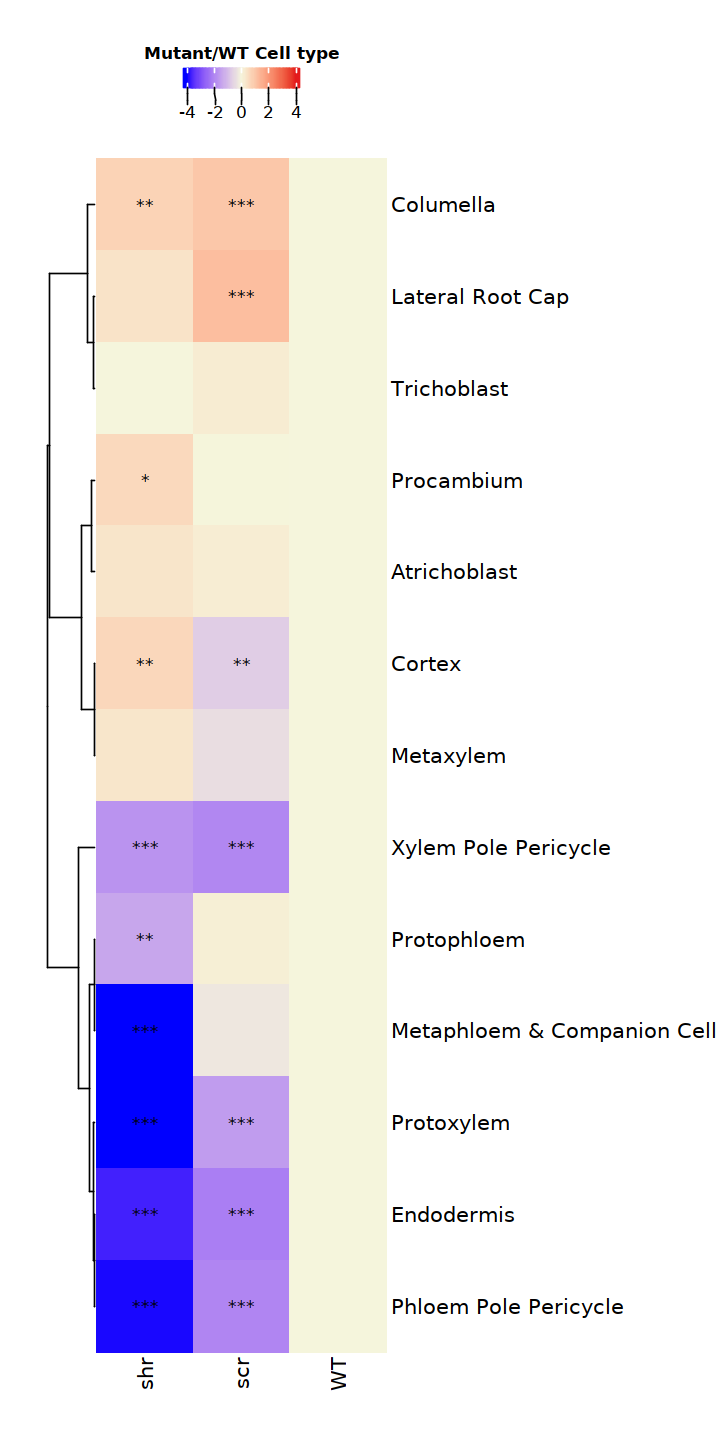

In [54]:
options(repr.plot.width=6, repr.plot.height=12)

vert_Cell_hm <- Heatmap(FC_wide_m, 
                name = "Mutant/WT Cell type", 
                col = colorRamp2(c(-4, 0, 4), c("blue", "beige", "#e31a1c")), 
                column_title = " ", 
                cluster_rows = T,
                cluster_columns = F, 
                clustering_distance_columns = "pearson", 
                clustering_distance_rows = "pearson",
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                show_column_dend = TRUE, 
                        heatmap_legend_param = list(title_position="topcenter", 
                                               color_bar = "continuous", 
                                               legend_direction = "horizontal"), 
                cell_fun = function(j, i, x, y, width, height, fill) 
                  {grid.text(sprintf("%s", star.wide_m[i, j]), x, y, gp = gpar(fontsize = 10))}) 

draw(vert_Cell_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")

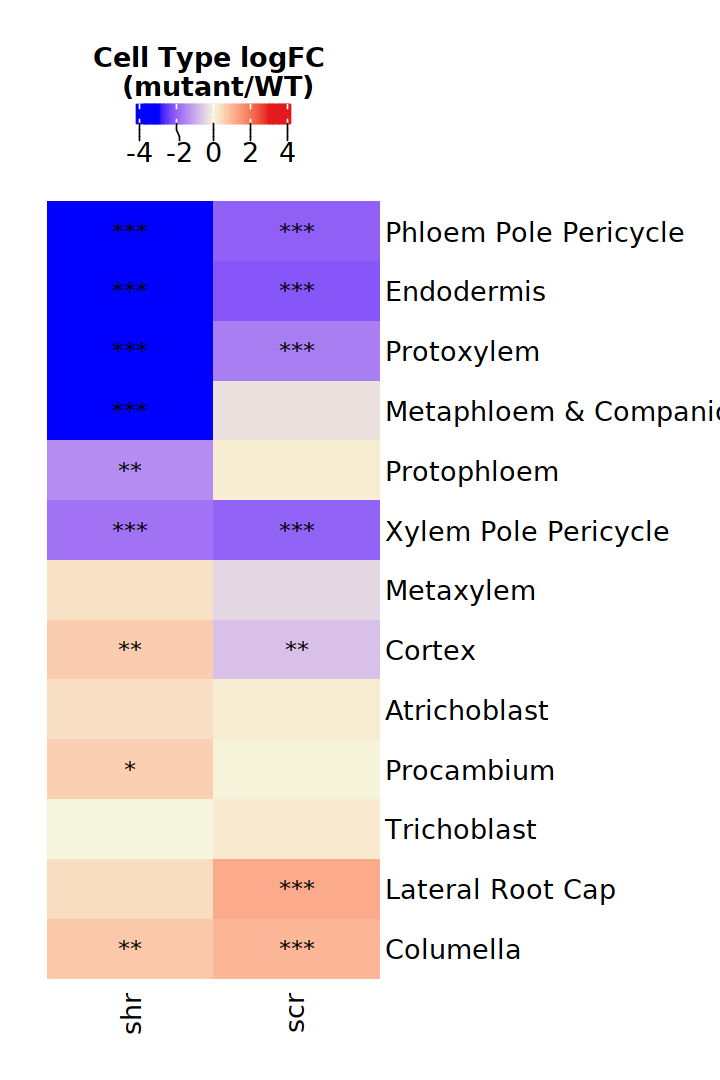

In [59]:
options(repr.plot.width=6, repr.plot.height=9)


FC_wide_m_2 <- FC_wide_m[c("Phloem Pole Pericycle", 
                           "Endodermis", 
                           "Protoxylem", 
                           "Metaphloem & Companion Cell", 
                           "Protophloem",  
                           "Xylem Pole Pericycle", 
                           "Metaxylem", 
                           "Cortex", 
                           "Atrichoblast", 
                           "Procambium", 
                           "Trichoblast", 
                           "Lateral Root Cap",
                           "Columella") , 
                         c("shr", "scr")]

star.wide_m_2 <- star.wide_m[c("Phloem Pole Pericycle", 
                           "Endodermis", 
                           "Protoxylem", 
                           "Metaphloem & Companion Cell", 
                           "Protophloem",  
                           "Xylem Pole Pericycle", 
                           "Metaxylem", 
                           "Cortex", 
                           "Atrichoblast", 
                           "Procambium", 
                           "Trichoblast", 
                           "Lateral Root Cap",
                           "Columella") , 
                         c("shr", "scr")]

col_lab_it <- c( 
              expression(italic("shr ")),
                expression(italic("scr ")))

vert_Cell_hm2 <- Heatmap(FC_wide_m_2, 
                name = "Cell Type logFC \n (mutant/WT)", 
                col = colorRamp2(c(-3, 0, 3), c("blue", "beige", "#e31a1c")), 
                column_title = " ", 
                cluster_rows = F,
                cluster_columns = F, 
                clustering_distance_columns = "pearson", 
                clustering_distance_rows = "pearson",
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                show_column_dend = TRUE, 
                         column_labels=col_lab_it,
                         column_names_gp = gpar(fontsize = 16),
                         row_names_gp = gpar(fontsize = 16),
                        heatmap_legend_param = list(title_position="topcenter", 
                                               color_bar = "continuous", 
                                               legend_direction = "horizontal", 
                                                   labels_gp = gpar(fontsize = 16), 
                                                   title_gp = gpar(fontsize = 16, font = 2), 
                                                   legend_height = unit(4, "cm")), 
                cell_fun = function(j, i, x, y, width, height, fill) 
                  {grid.text(sprintf("%s", star.wide_m_2[i, j]), x, y, gp = gpar(fontsize = 14))}) 

draw(vert_Cell_hm2, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


hm_final <- grid.grabExpr(draw(vert_Cell_hm2, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top"))

In [60]:
FC_wide_m_2 <- t(FC_wide_m_2)
rownames(FC_wide_m_2) <- c("shr-2", "scr-4")
star.wide_m_2 <- t(star.wide_m_2)
rownames(star.wide_m_2) <- c("shr-2", "scr-4")

In [61]:
FC_wide_m_2
star.wide_m_2

,Phloem Pole Pericycle,Endodermis,Protoxylem,Metaphloem & Companion Cell,Protophloem,Xylem Pole Pericycle,Metaxylem,Cortex,Atrichoblast,Procambium,Trichoblast,Lateral Root Cap,Columella
shr-2,-3.951323,-3.734158,-4.104489,-6.0088304,-1.4266895,-1.769132,0.3311102,0.6468625,0.3462554,0.60627138,-0.007227344,0.3863058,0.7304489
scr-4,-2.029241,-2.159982,-1.614856,-0.2564806,0.1370186,-1.991588,-0.4211563,-0.7177625,0.1634454,0.01038578,0.187841449,1.2003850,1.0023031


,Phloem Pole Pericycle,Endodermis,Protoxylem,Metaphloem & Companion Cell,Protophloem,Xylem Pole Pericycle,Metaxylem,Cortex,Atrichoblast,Procambium,Trichoblast,Lateral Root Cap,Columella
shr-2,***,***,***,***,**,***,,**,,*,,,**
scr-4,***,***,***,,,***,,**,,,,***,***


png 
  2

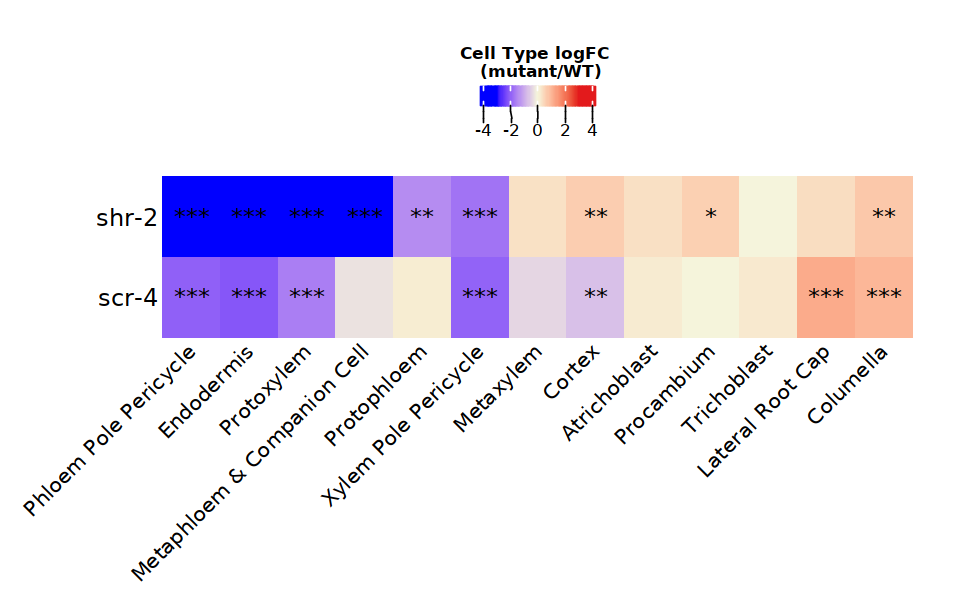

In [65]:
options(repr.plot.width=8, repr.plot.height=5)

hor_Cell_hm2 <- Heatmap(FC_wide_m_2, 
                name = "Cell Type logFC \n (mutant/WT)", 
                col = colorRamp2(c(-3, 0, 3), c("blue", "beige", "#e31a1c")), 
                column_title = " ", 
                cluster_rows = F,
                cluster_columns = F, 
                clustering_distance_columns = "pearson", 
                clustering_distance_rows = "pearson",
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                        row_names_side = "left",
                show_column_dend = TRUE, 
                        column_names_rot = 45,
                        heatmap_legend_param = list(title_position="topcenter", 
                                               color_bar = "continuous", 
                                               legend_direction = "horizontal"), 
                        row_names_gp = gpar(fontsize = 14, font = 3),
                cell_fun = function(j, i, x, y, width, height, fill) 
                  {grid.text(sprintf("%s", star.wide_m_2[i, j]), x, y, gp = gpar(fontsize = 14))}) 

draw(hor_Cell_hm2, padding = unit(c(10, 20, 10, 10), "mm"), heatmap_legend_side = "top")

pdf("./shr_scr_horizontal_DA.pdf", width = 8, height = 5)
draw(hor_Cell_hm2, padding = unit(c(10, 20, 10, 10), "mm"), heatmap_legend_side = "top")
dev.off()



## 6. Label transfer classification/prediction score

In [66]:
anno_scores <- data.frame(geno=rc.integrated$geno_trt, 
           prediction.score.Endodermis=rc.integrated$prediction.score.Endodermis, 
           prediction.score.Cortex=rc.integrated$prediction.score.Cortex, 
           annotation=rc.integrated$celltype.anno, 
                         timezone=rc.integrated$time.anno, 
                         consensus.time=rc.integrated$consensus.time.group)

In [81]:
anno_score_f <- anno_scores %>% filter(annotation %in% c("Cortex", "Endodermis")) %>% filter(timezone %in% c("Meristem", "Elongation", "Maturation")) %>% filter(is.na(prediction.score.Cortex)==F)

In [82]:
table(anno_score_f$timezone)


Elongation Maturation   Meristem 
      8578       3930       3494 

In [85]:
library(ggridges)

Picking joint bandwidth of 0.101



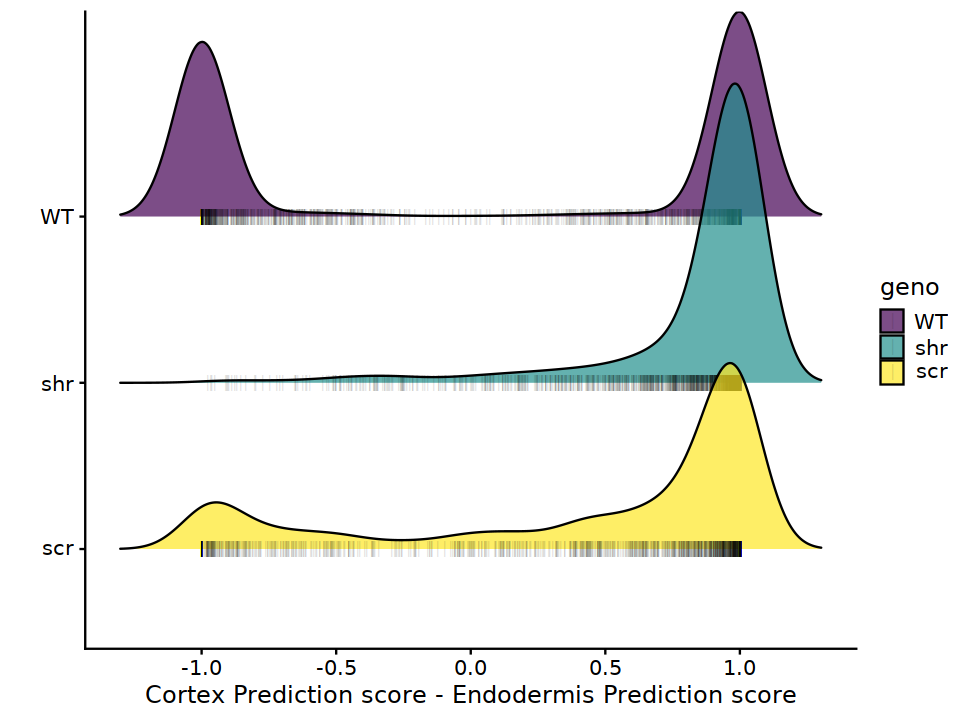

In [88]:
options(repr.plot.width=8, repr.plot.height=6)
pred_plot <- anno_scores %>% filter(annotation %in% c("Cortex", "Endodermis")) %>% filter(timezone %in% c("Meristem", "Elongation", "Maturation")) %>% filter(is.na(prediction.score.Cortex)==F) %>% 
mutate(Endodermis_Cortex_diff=prediction.score.Cortex-prediction.score.Endodermis)  %>%
ggplot(aes(y=factor(geno, levels=c("scr", "shr", "WT")), x=Endodermis_Cortex_diff, fill=geno)) + geom_density_ridges(jittered_points = TRUE,
    position = position_points_jitter(width = 0.001, height = 0),
    point_shape = '|', point_size = 3, point_alpha = 0.1, alpha=0.7
  )
mylabels <- c( 
              expression(italic("scr")),
                expression(italic("shr")), "WT")
pred_plot <- pred_plot + 
theme_cowplot() + 
xlab("Cortex Prediction score - Endodermis Prediction score") + 
ylab("") + 
scale_fill_viridis_d(labels = rev(mylabels)) + 
scale_y_discrete(labels = mylabels)
pred_plot

Picking joint bandwidth of 0.142

Picking joint bandwidth of 0.0878

Picking joint bandwidth of 0.016



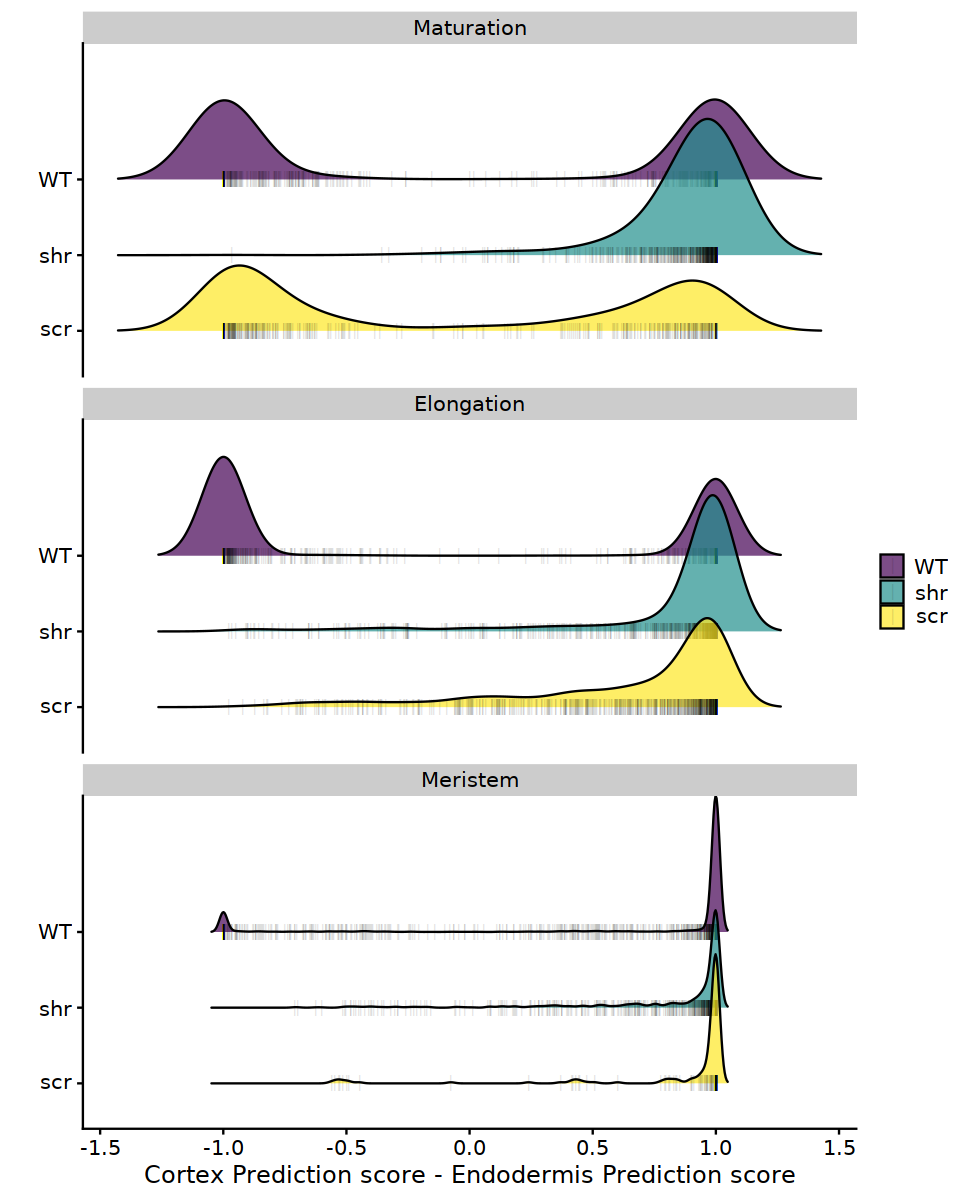

In [89]:
options(repr.plot.width=8, repr.plot.height=10)
pred_plot <- pred_plot + facet_wrap(~ factor(timezone, levels=c("Maturation","Elongation","Meristem")), ncol = 1) + theme(legend.title = element_blank())
pred_plot

x,y,t
<dbl>,<dbl>,<chr>
1,1.0,a
1,2.0,a
16,1.5,a
16,1.7,b
16,2.7,b
1,2.2,b


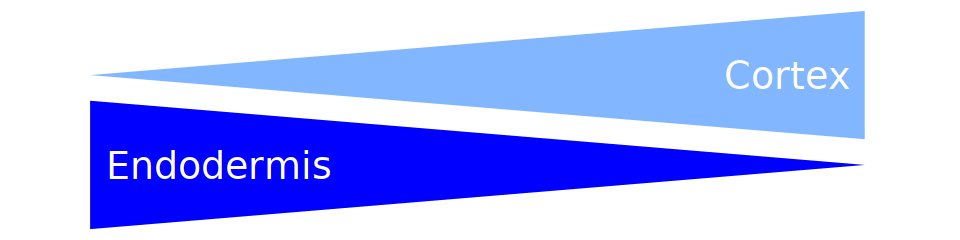

In [73]:
# make triangles 
options(repr.plot.width=8, repr.plot.height=2)

d=data.frame(x=c(1,1,16, 16,16,1), y=c(1,2,1.5, 1.7,2.7,2.2), t=c('a', 'a', 'a', 'b', 'b', 'b'))
d
triangle_label <- ggplot() +
geom_polygon(data=d, mapping=aes(x=x, y=y, group=t, fill=t)) + annotate("text", x = 3.5, y = 1.5, label = "Endodermis", size = 8, color="white") + 
annotate("text", x = 14.5, y = 2.2, label = "Cortex", size = 8, color="white") + 
scale_fill_manual(values=(c("#0000FF", "#82B6FF"))) + theme_nothing() + scale_x_continuous(limits=c(0.1, 17))

triangle_label

Picking joint bandwidth of 0.142

Picking joint bandwidth of 0.0878

Picking joint bandwidth of 0.016



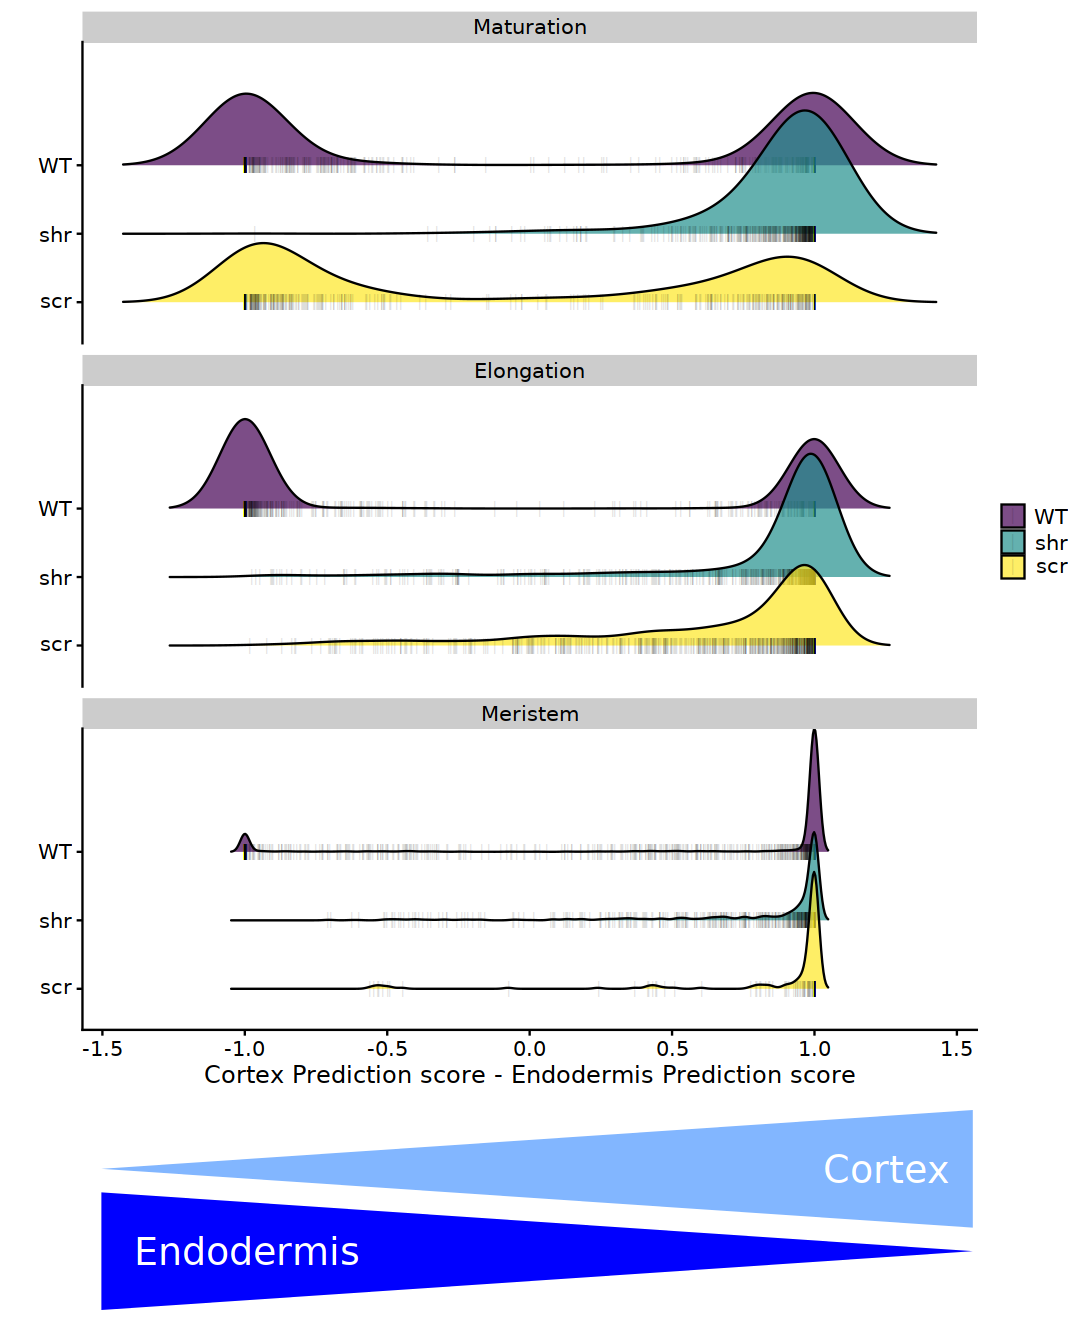

In [90]:
options(repr.plot.width=9, repr.plot.height=11)

(pred_tri <- plot_grid(pred_plot, triangle_label, ncol=1, rel_heights = c(1, .2)))

#ggsave("./WT_shr_scr_prediction_ridgeplot.pdf", width=9, height=10)

#ggsave("./WT_shr_scr_prediction_ridgeplot_taller.pdf", width=9, height=11)

#ggsave("./WT_shr_scr_prediction_ridgeplot_tallest.pdf", width=9, height=12)

In [65]:
# swtich direction 

Picking joint bandwidth of 0.101



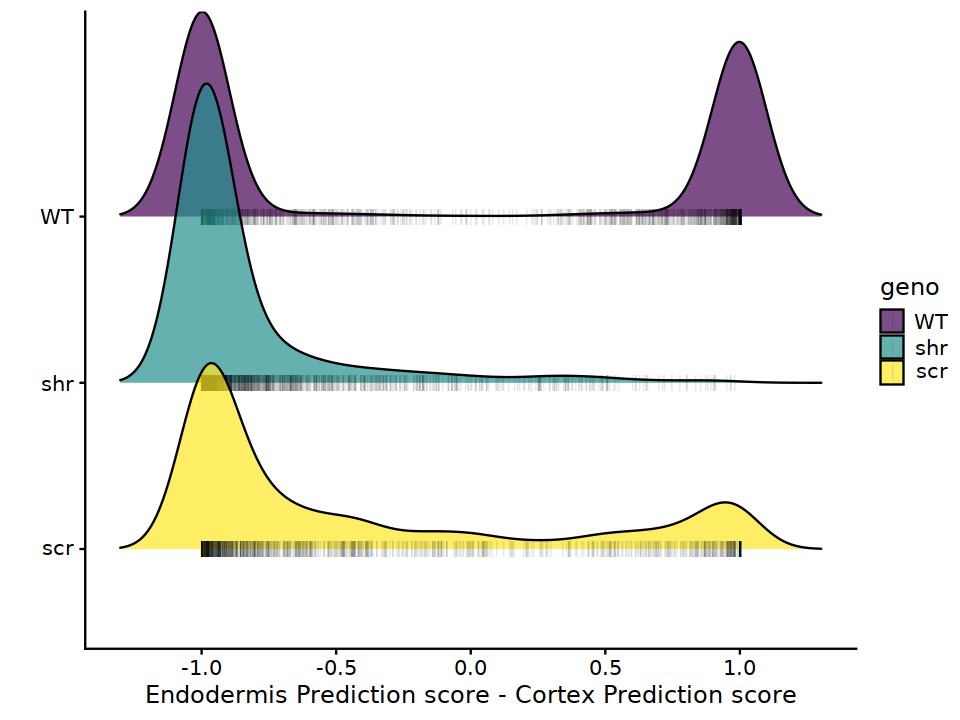

In [91]:
options(repr.plot.width=8, repr.plot.height=6)
pred_plot <- anno_scores %>% filter(annotation %in% c("Cortex", "Endodermis")) %>% filter(timezone %in% c("Meristem", "Elongation", "Maturation")) %>% filter(is.na(prediction.score.Cortex)==F) %>% 
mutate(Cortex_Endodermis_diff=prediction.score.Endodermis-prediction.score.Cortex)  %>%
ggplot(aes(y=factor(geno, levels=c("scr", "shr", "WT")), x=Cortex_Endodermis_diff, fill=geno)) + geom_density_ridges(jittered_points = TRUE,
    position = position_points_jitter(width = 0.001, height = 0),
    point_shape = '|', point_size = 3, point_alpha = 0.1, alpha=0.7
  )
mylabels <- c( 
              expression(italic("scr")),
                expression(italic("shr")), "WT")
pred_plot <- pred_plot + 
theme_cowplot() + 
xlab("Endodermis Prediction score - Cortex Prediction score") + 
ylab("") + 
scale_fill_viridis_d(labels = rev(mylabels)) + 
scale_y_discrete(labels = mylabels)
pred_plot

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Picking joint bandwidth of 0.016

Picking joint bandwidth of 0.0878

Picking joint bandwidth of 0.142



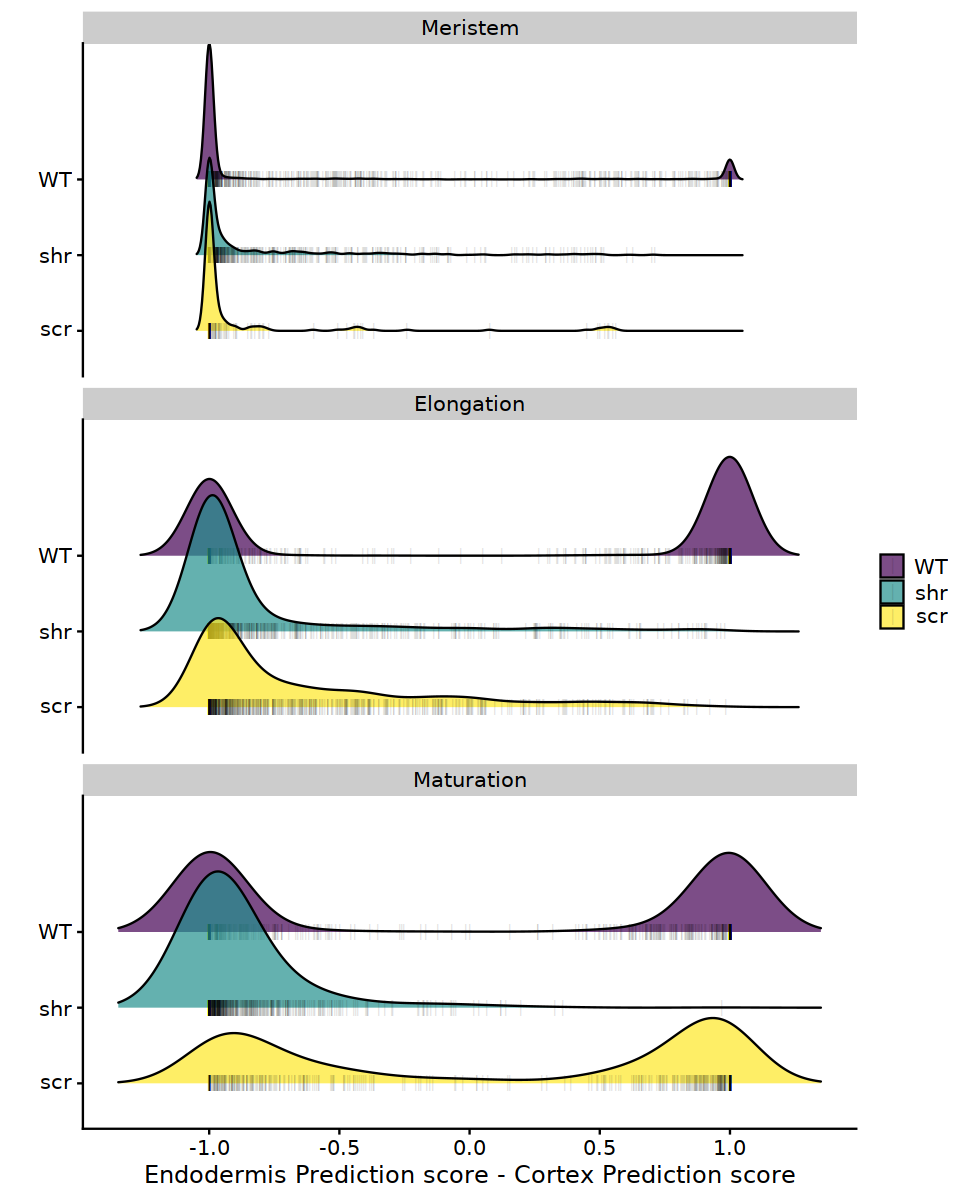

In [105]:
options(repr.plot.width=8, repr.plot.height=10)
pred_plot <- pred_plot + facet_wrap(~ factor(timezone, levels=c("Meristem","Elongation","Maturation")), ncol = 1) + theme(legend.title = element_blank()) + xlim(-1.35,1.35)
pred_plot

x,y,t
<dbl>,<dbl>,<chr>
3.3,1.0,a
3.3,2.0,a
13.4,1.5,a
13.4,1.7,b
13.4,2.7,b
3.3,2.2,b


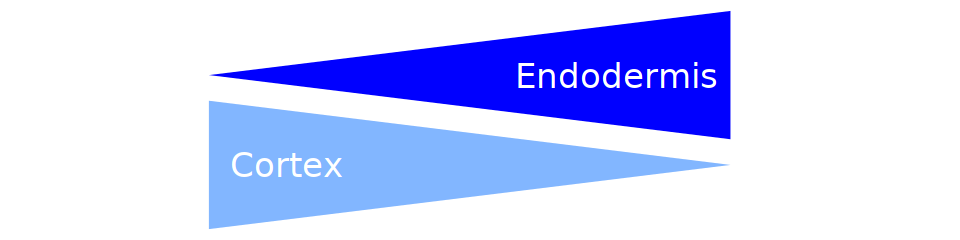

In [126]:
# make triangles 
options(repr.plot.width=8, repr.plot.height=2)

d=data.frame(x=c(3.3,3.3,13.4, 13.4,13.4,3.3), y=c(1,2,1.5, 1.7,2.7,2.2), t=c('a', 'a', 'a', 'b', 'b', 'b'))
d
triangle_label <- ggplot() +
geom_polygon(data=d, mapping=aes(x=x, y=y, group=t, fill=t)) + annotate("text", x = 4.8, y = 1.5, label = "Cortex", size = 7, color="white") + 
annotate("text", x = 11.2, y = 2.2, label = "Endodermis", size = 7, color="white") + 
scale_fill_manual(values=(c("#82B6FF","#0000FF"))) + theme_nothing() + scale_x_continuous(limits=c(0.1, 17))

triangle_label

Picking joint bandwidth of 0.016

Picking joint bandwidth of 0.0878

Picking joint bandwidth of 0.142

Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


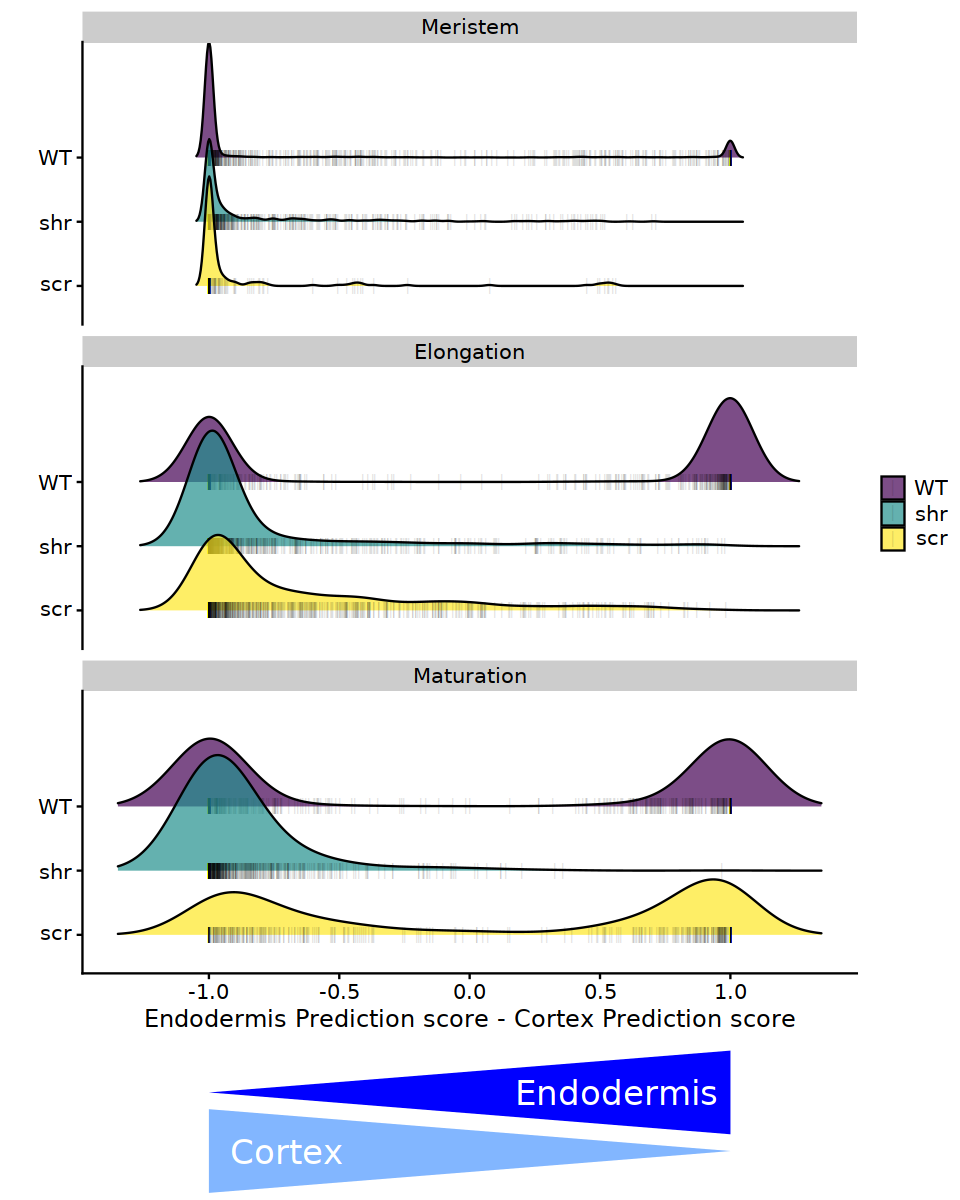

In [127]:
options(repr.plot.width=8, repr.plot.height=10)

(pred_tri <- plot_grid(pred_plot, triangle_label, ncol=1, rel_heights = c(1, .15), align="v"))